EAE3709 Aplicaciones de Machine Learning en Economía <br>
Primer Semestre 2025

Instituto de Economía<br>
Pontificia Universidad Católica de Chile


 # **Proyecto Final: ¿Dónde es más riesgoso vivir? Un modelo predictivo de victimización territorial basado en características individuales**


- Autores:
    - **Catalina Aránguiz**  [<caranguizc@estudiante.uc.cl>]
    - **Maykol Medrano**  [<mmedrano@uc.cl>]
    
- Fecha: [30-06-2025]

  **Repo del proyecto** : https://github.com/MaykolMedrano/ML-Crime
__________________________________________________________


## **Descripción del proyecto**

- **Contexto área del conocimiento**

La seguridad ciudadana es uno de los principales desafíos de política pública en Chile. El aumento sostenido en la percepción de inseguridad y las tasas de victimización reportadas por encuestas oficiales han motivado la búsqueda de herramientas analíticas que permitan anticipar y focalizar los esfuerzos preventivos de forma eficiente. En este contexto, el aprendizaje automático ofrece nuevas posibilidades para modelar patrones complejos de victimización en función de variables individuales, contextuales y territoriales, contribuyendo a una gestión más inteligente de la seguridad urbana.

- **Pregunta de investigación**

¿Qué zonas de Chile presentan mayor riesgo de victimización, según las características individuales y del entorno urbano, estimadas a partir de modelos de aprendizaje automático?

- **Fuente de información principal**

Los datos provienen de la **Encuesta Nacional Urbana de Seguridad Ciudadana (ENUSC) 2023**, levantada por el Instituto Nacional de Estadísticas y el Ministerio del Interior. Esta fuente permite acceder a información detallada a nivel individual sobre experiencias de victimización, condiciones socioeconómicas, y percepciones de seguridad, con cobertura territorial a nivel de comuna.

### **Contenido**
1. [Pre-procesamiento](#seccion1)
2. [Análisis Exploratorio de Datos (EDA](#seccion2))
3. [Feature Engineering](#seccion3)
4. [Entrenamiento](#seccion4)
5. [Evaluación](#seccion5)
6. [Explicabalidad](#seccion6)
7. [Conclusiones](#seccion7)
__________________________________________________________

## 1. Pre-procesamiento <a name="seccion1"></a>
Incluir en esta sección:
- Importación de librerías principales
- Carga del data frame
- Integración con otros sets de datos (si aplica)
- Descripción inicial de las columnas:
    - tipo de datos
    - evaluar presencia de missings y outliers
- Construcción de la variable objetivo o target (si aplica)

In [120]:
# Instalar y cargar dependencias
!pip install -q pyreadstat pingouin factor_analyzer pandas pyarrow
!apt-get -qq update
!apt-get -qq install -y unrar
!pip install -q lime

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [121]:
# ============================
# IMPORTS ORGANIZADOS
# ============================

# 0. Librerías estándar
import glob
import os
import pathlib
import subprocess
import textwrap
import time
import warnings
import zipfile

# 1. Ciencia de datos y matrices
import numpy as np
import pandas as pd
import pyreadstat

# 2. Visualización
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import missingno as msno
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import shap

# 3. Estadística y psicometría
from factor_analyzer import FactorAnalyzer
from pingouin import cronbach_alpha
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
from scipy.stats.mstats import winsorize

# 4. Machine Learning ─ scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC

# 5. XGBoost
from xgboost import XGBClassifier

# 6. Manejo de desbalanceo
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 7. Colecciones y utilidades adicionales
from collections import Counter

In [122]:
# Definir URL y descargar el archivo
FILE_URL = "https://github.com/MaykolMedrano/ML-Crime/raw/master/base-usuario-20-enusc-2023.zip"
FILE_NAME = FILE_URL.split('/')[-1]

!wget -q "$FILE_URL" -O "$FILE_NAME"   # -q = descarga silenciosa

# Descomprimir (.zip o .rar, según corresponda)
def extract(path):
    path = pathlib.Path(path)
    if path.suffix == ".zip":
        with zipfile.ZipFile(path, 'r') as z:
            z.extractall()           # extrae en el directorio actual
    elif path.suffix == ".rar":
        subprocess.run(["unrar", "x", "-y", str(path)], check=True)
    else:
        raise ValueError("Formato no soportado: solo .zip o .rar")

extract(FILE_NAME)

**IMPORTANTE**: Se proporciona sample de dataset

In [126]:
# csv_url = "https://raw.githubusercontent.com/MaykolMedrano/ML-Crime/refs/heads/master/muestra_entrenamiento_evaluacion.csv"
# df     = pd.read_csv(csv_url)
# df.head()

,rph_ID,idhogar,enc_idr,enc_region,enc_rpc,com102,IH_residencia_habitual,IH_comparte_gastos,IH_numero_grupos,IH_cantidad_hogar,...,EXT_LOCAL,SOB_LOCAL,Fact_Pers_Com,Fact_Pers_Reg,Fact_Pers_Regional_102,Fact_Hog_Com,Fact_Hog_Reg,Fact_Hog_Regional_102,VarStrat,Conglomerado
0,84-83-87-90_1,84-83-87-90-H1,23378.0,5,5701,1.0,3.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,169.665857,NaN,NaN,60.888912,NaN,NaN
1,53-30-75-61_6,53-30-75-61-H1,17810.0,4,4301,1.0,6.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,471.293255,NaN,NaN,91.598542,NaN,NaN
2,52-81-42-09_4,52-81-42-09-H1,16703.0,4,4102,1.0,8.0,1.0,NaN,1.0,...,0.0,0.0,900.196159,974.102654,992.951918,167.575306,216.198168,220.590774,20234102.0,2.023001e+09
3,60-32-99-49_5,60-32-99-49-H1,56422.0,13,13112,1.0,5.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,1680.204648,NaN,NaN,287.242557,NaN,NaN
4,05-45-77-91_5,05-45-77-91-H1,21155.0,5,5301,1.0,5.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,257.887295,NaN,NaN,69.464503,NaN,NaN


In [123]:
# Cargamos base de datos ENUSC 2023
df = pd.read_spss("base-usuario-20-enusc-2023.sav", convert_categoricals=False)
print(df.shape)
df.head()

(146294, 1301)


,rph_ID,idhogar,enc_idr,enc_region,enc_rpc,com102,IH_residencia_habitual,IH_comparte_gastos,IH_numero_grupos,IH_cantidad_hogar,...,EXT_LOCAL,SOB_LOCAL,Fact_Pers_Com,Fact_Pers_Reg,Fact_Pers_Regional_102,Fact_Hog_Com,Fact_Hog_Reg,Fact_Hog_Regional_102,VarStrat,Conglomerado
0,00-00-33-94_1,00-00-33-94-H1,7479.0,10,10101,1.0,4.0,1.0,NaN,1.0,...,0.0,0.0,425.245263,519.894835,591.228012,155.960818,192.60032,221.462682,20240101.0,2.023004e+09
1,00-00-33-94_2,00-00-33-94-H1,7479.0,10,10101,1.0,4.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,591.228012,NaN,NaN,221.462682,NaN,NaN
2,00-00-33-94_3,00-00-33-94-H1,7479.0,10,10101,1.0,4.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,591.228012,NaN,NaN,221.462682,NaN,NaN
3,00-00-33-94_4,00-00-33-94-H1,7479.0,10,10101,1.0,4.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,591.228012,NaN,NaN,221.462682,NaN,NaN
4,00-00-41-76_1,00-00-41-76-H1,46130.0,10,10202,1.0,4.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,222.646726,NaN,NaN,64.841374,NaN,NaN


### **Filtro Kish: Selección de Representante Único por Hogar**

La **selección Kish == 1** implementa muestreo aleatorio intra-hogar que asegura independencia de observaciones, principio fundamental para validez estadística en modelos de ML. Sin este filtro, múltiples miembros del mismo hogar introducirían **clustering effects** donde observaciones comparten contexto territorial, socioeconómico y de exposición al riesgo, violando assumption de independencia que sustenta inferencia estadística y cross-validation robusta.

El **método de selección Kish** utiliza tabla de números aleatorios para elegir un miembro adulto por hogar, eliminando sesgos de disponibilidad (quién está en casa durante entrevista) y sesgos de selección intencional (elegir al miembro más dispuesto a responder). Esta randomización intra-hogar asegura que la muestra final sea **representativa de la población adulta nacional**, no sesgada hacia perfiles demográficos específicos que podrían estar over/under-represented en muestras de conveniencia.

Dado que el modelo predice **riesgo individual de victimización**, mantener múltiples observaciones del mismo hogar introduciría redundancia informativa y tamaño de muestra artificial. La selección de un representante único maximiza **diversidad territorial y sociodemográfica** en la muestra, proporcionando mayor variabilidad en features predictivos y mejorando capacidad de generalización del modelo a individuos en diferentes contextos household y territoriales.

La **aplicación del filtro Kish respeta el diseño muestral original** de ENUSC, manteniendo ponderadores (`Fact_Pers_Com`, `Fact_Pers_Reg`) calibrados para esta selección específica. Omitir este filtro requeriría recalibration de pesos muestrales y potencialmente introduciría sesgo en estomaciones poblacionales, comprometiendo la validez externa de los resultados y su aplicabilidad para policy nacional.

In [ ]:
df = df[df['Kish'] == 1].copy()


### **Justificación de selección de features para predicción de victimización**

 * #### **Marco teórico integrado**

La selección de variables se fundamenta en tres marcos teóricos consolidados de la criminología contemporánea. La **Teoría de actividades rutinarias** justifica la inclusión de variables de exposición territorial y patrones de actividad que determinan la convergencia espacio-temporal entre víctimas potenciales y offenders motivados. La **Teoría de desorganización social** sustenta las variables de percepción de desorden, cohesión comunitaria y eficacia colectiva como predictores de control social informal. La **Criminología ambiental** fundamenta las variables de contexto territorial, presencia institucional y señales de deterioro físico como determinantes del riesgo situacional.

 * #### **Variables sociodemográficas: Predictores baseline**

Las características individuales (edad, sexo, educación, NSE) constituyen el núcleo predictivo fundamental basado en décadas de evidencia criminológica sobre victimización diferencial. Estos factores determinan patrones de exposición, vulnerabilidad y capacidades de autoprotección. Variables de identidad (origen étnico, nacionalidad) capturan interseccionalidades específicas del contexto chileno, mientras que situación laboral y discapacidad reflejan vulnerabilidades socioeconómicas que la literatura asocia consistentemente con mayor riesgo de victimización.

* #### **Variables perceptuales: Núcleo innovador del modelo**

Las variables de percepción de desorden e incivilidades operacionalizan la "Teoría de Ventanas Rotas", donde deterioro físico y social observable predice criminalidad futura. Estas variables proporcionan indicadores tempranos de riesgo territorial que anteceden la materialización de delitos. La percepción de presencia de tráfico de drogas y armas captura exposición directa a actividad criminal, funcionando como proxy de riesgo contextual cuando datos administrativos objetivos no están disponibles a nivel individual.

* #### **Variables de respuesta adaptativa**

Las medidas de organización comunitaria y protección individual reflejan respuestas adaptativas al riesgo que modifican la probabilidad baseline de victimización. Variables de cohesión vecinal y acciones colectivas operacionalizan la "eficacia colectiva" como factor protector, mientras que medidas de seguridad individual capturan estrategias de autoprotección. La confianza institucional y evaluación policial funcionan como proxy de calidad de respuesta estatal territorial, determinando tanto la efectividad preventiva como la probabilidad de denuncia.

* #### **Consideraciones metodológicas de ML**

La selección prioriza variables con calidad de medición adecuada para ML, evitando features con alta tasa de missing values o measurement error sistemático. Se incluyen variables de múltiples niveles (individual, comunitario, territorial) para prevenir underfitting, mientras que la agrupación en índices psicométricos reduce multicolinealidad preservando información teóricamente relevante. Variables territoriales permiten validación espacial robusta y control de heterogeneidad no observada.

* #### **Exclusiones deliberadas**

Se excluyen deliberadamente variables de victimización pasada por endogeneidad (causarían data leakage), datos administrativos por disponibilidad limitada en ENUSC, y variables de ingresos exactos por calidad de datos problemática. Esta selección equilibra cobertura teórica, viabilidad metodológica y relevancia para política pública, resultando en un conjunto de 68 variables que proporciona base empírica sólida para predicción de victimización individual con consideración territorial.

### **Variables del Modelo de Predicción de Victimización (ENUSC 2023)**

## I. Variables Geográficas y Contexto Territorial

| Variable | Descripción |
|----------|-------------|
| `enc_rpc` | Región, provincia y comuna |
| `enc_region` | Código de región |
| `PRESENCIA_CARABINEROS` | Percepción de presencia policial en el sector |
| `ANTIG_SECTOR` | Antigüedad de residencia en el sector |

---

## II. Variables Sociodemográficas Individuales

### Características Básicas
| Variable | Descripción |
|----------|-------------|
| `rph_edad` | Edad del entrevistado |
| `rph_sexo` | Sexo del entrevistado |
| `rph_nivel` | Nivel educacional máximo alcanzado |
| `rph_nse` | Nivel socioeconómico autopercibido |

### Identidad y Origen
| Variable | Descripción |
|----------|-------------|
| `rph_pertenencia_indigena` | Pertenencia a pueblo indígena |
| `rph_nacionalidad` | Nacionalidad (chilena/extranjera) |


### Situación Laboral y Funcional
| Variable | Descripción |
|----------|-------------|
| `rph_situacion_laboral_a` | Situación laboral actual |
| `rph_disc_a` a `rph_disc_f` | Indicadores de situación de discapacidad |

---

## III. Variables Perceptuales de Seguridad y Entorno

### Percepción de Desórdenes Territoriales
| Variables | Descripción |
|-----------|-------------|
| `P_DESORDENES_1` a `P_DESORDENES_8` | Frecuencia de problemas en el barrio:<br>• Rayados y grafitis<br>• Personas durmiendo en la calle<br>• Comercio ambulante<br>• Consumo de alcohol/drogas<br>• Venta clandestina de alcohol<br>• Basura y sitios eriazos<br>• Prostitución<br>• Uso de fuegos artificiales |

### Percepción de Incivilidades y Delitos
| Variables | Descripción |
|-----------|-------------|
| `P_INCIVILIDADES_1` a `P_INCIVILIDADES_7` | Frecuencia de delitos observados:<br>• Peleas callejeras<br>• Vandalismo<br>• Presencia de pandillas<br>• Venta de drogas<br>• Consumo de drogas<br>• Robos y asaltos<br>• Balaceras |

### Exposición a Criminalidad
| Variable | Descripción |
|----------|-------------|
| `PRESENCIA_TRAFICO` | Frecuencia observada de tráfico de drogas |
| `PRESENCIA_ARMAS` | Frecuencia observada de porte de armas |
| `P_EXPOS_DELITO` | Percepción de riesgo personal futuro |

### Modificación de Comportamientos
| Variable | Descripción |
|----------|-------------|
| `P_MOD_ACTIVIDADES_1` a `P_MOD_ACTIVIDADES_12` | Cambios en actividades por temor al delito |

---

## IV. Variables de Confianza Institucional

| Variable | Descripción |
|----------|-------------|
| `EV_CONFIA_CCH` | Nivel de confianza en Carabineros |
| `EVAL_ACUDE` a `EVAL_MEDIACION` | Evaluación de acciones municipales de seguridad |
| `EVAL_CARAB_COMUNA_1` a `EVAL_CARAB_COMUNA_6` | Evaluación del desempeño de Carabineros en la comuna |

---

## V. Variables de Organización Comunitaria y Medidas de Protección

### Medidas de Seguridad Individuales
| Variable | Descripción |
|----------|-------------|
| `MEDIDAS_PERRO` a `MEDIDAS_OTRO` | Medidas de seguridad implementadas en la vivienda |
| `ADOPTADAS_PERRO` a `ADOPTADAS_OTRO` | Medidas de seguridad adoptadas recientemente |


### Organización y Acción Comunitaria
| Variable | Descripción |
|----------|-------------|
| `VECINOS_MEDIDAS_WHATSAPP` | Grupos de WhatsApp de seguridad vecinal |
| `VECINOS_MEDIDAS_VIGILANCIA` | Rondas o vigilancia comunitaria |
| `VECINOS_MEDIDAS_AL_COMUNIT` | Alarmas comunitarias |
| `VECINOS_MEDIDAS_COODR_POL` | Coordinación con Carabineros |
| `VECINOS_MEDIDAS_COODR_MUN` | Coordinación con municipio |
| `VECINOS_MEDIDAS_TELEVIG` | Televigilancia comunitaria |
| `VECINOS_MEDIDAS_PRIVAD` | Seguridad privada contratada |

### Cohesión Social y Capital Comunitario
| Variable | Descripción |
|----------|-------------|
| `P_ACCIONES_VECINOS_1` a `P_ACCIONES_VECINOS_5` | Número de acciones realizadas con vecinos |
| `ADOPTADAS_MEDIDAS_WHATSAPP` a `ADOPTADAS_MEDIDAS_PRIVAD` | Adopción reciente de medidas comunitarias |

### Tenencia de Armas
| Variable | Descripción |
|----------|-------------|
| `POSESION_ARMA` | Tenencia de arma de fuego en el hogar |
| `MOTIVO_ARMA` | Motivo de tenencia (protección/otro) |

---

## VI. Variable Objetivo

| Variable | Descripción | Tipo |
|----------|-------------|------|
| **`VP_DC`** | **Victimización personal por delitos consultados** | **Binaria (0/1)** |

> **Nota**: Esta variable indica si la persona fue víctima de algún delito en los últimos 12 meses, constituyendo la variable dependiente principal del modelo de clasificación.

---

## Resumen de Dimensiones

| **Categoría** | **N° Variables** | **Tipo Principal** |
|---------------|------------------|--------------------|
| Geográficas y territoriales | 4 | Categóricas/Continuas |
| Sociodemográficas | 10 | Categóricas/Binarias |
| Perceptuales de seguridad | 27 | Ordinales (escalas Likert) |
| Confianza institucional | 9 | Ordinales |
| Organización comunitaria | 17 | Binarias/Continuas |
| **Variable objetivo** | **1** | **Binaria** |
| **TOTAL** | **68** | **Mixed** |

In [ ]:
# Variables base necesarias para Modelo
variables_base = [
    # Variables Individuales (11 directas)
    'rph_edad','rph_sexo','rph_nivel','rph_nse',
    'rph_situacion_laboral_a','rph_pertenencia_indigena',
    'rph_nacionalidad',

    # Variables Territoriales (2)
    'enc_region',

    # Variables Contexto Territorial (2)
    'PRESENCIA_CARABINEROS',
    'PRESENCIA_TRAFICO',      # Para crear presencia_criminalidad
    'PRESENCIA_ARMAS',        # Para crear presencia_criminalidad

    # Variable Confianza (1)
    'EV_CONFIA_CCH',
]

# Variables necesarias para crear ÍNDICES AGREGADOS
variables_para_indices = [
    # Para indice_desorden_barrio (P_DESORDENES_1 a _8)
    'P_DESORDENES_1', 'P_DESORDENES_2', 'P_DESORDENES_3', 'P_DESORDENES_4',
    'P_DESORDENES_5', 'P_DESORDENES_6', 'P_DESORDENES_7', 'P_DESORDENES_8',

    # Para indice_incivilidades (P_INCIVILIDADES_1 a _7)
    'P_INCIVILIDADES_1', 'P_INCIVILIDADES_2', 'P_INCIVILIDADES_3',
    'P_INCIVILIDADES_4', 'P_INCIVILIDADES_5', 'P_INCIVILIDADES_6', 'P_INCIVILIDADES_7',

    # Para organizacion_comunitaria (VECINOS_MEDIDAS_* todas)
    'VECINOS_MEDIDAS_WHATSAPP','VECINOS_MEDIDAS_VIGILANCIA','VECINOS_MEDIDAS_AL_COMUNIT','VECINOS_MEDIDAS_COODR_POL',
    'VECINOS_MEDIDAS_COODR_MUN','VECINOS_MEDIDAS_TELEVIG','VECINOS_MEDIDAS_PRIVAD'
]

# Variables para crear discapacidad_binaria
variables_discapacidad = [
    'rph_disc_a', 'rph_disc_b', 'rph_disc_c',
    'rph_disc_d', 'rph_disc_e', 'rph_disc_f'
]

# Buscar variable de cohesión social (necesitas verificar nombres exactos)
# Estas probablemente se llaman P_ACCIONES_VECINOS_1 a _5 o similar
variables_cohesion = [
    # NOTA: Verifica los nombres exactos en tu dataset
    'P_ACCIONES_VECINOS_1', 'P_ACCIONES_VECINOS_2', 'P_ACCIONES_VECINOS_3',
    'P_ACCIONES_VECINOS_4', 'P_ACCIONES_VECINOS_5'
]

# Variable de antigüedad
variables_adicionales = [
    'ANTIG_SECTOR'
]

# Variable TARGET
target_variable = ['VP_DC']

# Buscar PONDERADOR (verificar nombre exacto en tu dataset)
ponderadores = [
  'Fact_Pers_Com',    'Fact_Pers_Reg'
]

# Variables finales
variables_modelo = (variables_base + variables_para_indices + variables_discapacidad +
                    variables_cohesion + variables_adicionales + target_variable + ponderadores)

print("FEATURES SELECCIONADOS")
print(f"Variables base individuales:  {len(variables_base)}")
print(f"Variables para índices:       {len(variables_para_indices)}")
print(f"Variables discapacidad:       {len(variables_discapacidad)}")
print(f"Total variables para filtrar: {len(variables_modelo)}")

# Filtrar dataset
df = df[variables_modelo].copy() # Use df from previous cell and create a copy

df_modelo = df.replace({88: np.nan, 86: np.nan, 96: np.nan, 99: np.nan})
df_modelo.columns = df_modelo.columns.str.lower()

# Metadata de nuestro DataFrame usamos la función info()
df_modelo.info()

FEATURES SELECCIONADOS
Variables base individuales:  12
Variables para índices:       22
Variables discapacidad:       6
Total variables para filtrar: 49
<class 'pandas.core.frame.DataFrame'>
Index: 49813 entries, 0 to 146291
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   rph_edad                    49813 non-null  float64
 1   rph_sexo                    49813 non-null  float64
 2   rph_nivel                   49414 non-null  float64
 3   rph_nse                     49813 non-null  float64
 4   rph_situacion_laboral_a     49813 non-null  float64
 5   rph_pertenencia_indigena    49008 non-null  float64
 6   rph_nacionalidad            49737 non-null  float64
 7   enc_region                  49813 non-null  object 
 8   presencia_carabineros       48497 non-null  float64
 9   presencia_trafico           49192 non-null  float64
 10  presencia_armas             49437 non-null  float64


In [ ]:
# Tipo de variables del DataFrame usamos la función .dtypes
df_modelo.dtypes

,0
rph_edad,float64
rph_sexo,float64
rph_nivel,float64
rph_nse,float64
rph_situacion_laboral_a,float64
rph_pertenencia_indigena,float64
rph_nacionalidad,float64
enc_region,object
presencia_carabineros,float64
presencia_trafico,float64


In [ ]:
# Reporte de valores faltantes por columna
reporte_nan = df_modelo.isna().sum().sort_values(ascending=False)

# Agregamos el porcentaje de NaNs
reporte_nan_pct = (df_modelo.isna().mean() * 100).sort_values(ascending=False)

# Combinar en un DataFrame limpio
reporte = pd.DataFrame({
    'n° faltantes': reporte_nan,
    'faltante (%)': reporte_nan_pct
})
reporte

,n° faltantes,faltante (%)
ev_confia_cch,18367,36.871901
vecinos_medidas_coodr_mun,9478,19.027162
vecinos_medidas_coodr_pol,8893,17.852769
p_desordenes_5,5026,10.089736
p_desordenes_7,3098,6.219260
vecinos_medidas_whatsapp,2413,4.844117
p_acciones_vecinos_4,1982,3.978881
vecinos_medidas_al_comunit,1930,3.874491
vecinos_medidas_vigilancia,1920,3.854416
vecinos_medidas_televig,1872,3.758055


### **Diagnóstico de missing values**

* Tras seleccionar las variables teóricamente relevantes, evaluamos la **completitud empírica** de los datos para informar estrategias de preprocessing. Missing values no aleatorios pueden introducir sesgos sistemáticos y comprometer tanto la representatividad muestral como el performance del modelo.

* El diagnóstico revela **tres grupos distintivos**: (1) **Variables sociodemográficas básicas** con 0% missings (edad, sexo, NSE, región, variable objetivo), reflejando robustez del diseño ENUSC; (2) **Variables perceptuales** con missings moderados (1-10%), manejables mediante imputación simple; (3) **Variables de evaluación institucional y participación comunitaria** con missings altos (15-37%), especialmente confianza en Carabineros (36.87%), sugiriendo patrones **Missing not a random** donde la no-respuesta puede correlacionar con actitudes hacia las instituciones.

## 2. Análisis Exploratorio de Datos <a name="seccion2"></a>
Incluir en esta sección:
- Análisis descriptivo de cada atributo y la variable objetivo
    - Distribución variables contínuas
    - Conteo de presencia de cada estado en variables categóricas
    - Evaluar potencial predictivo de atributos sobre target:
        - Matriz de correlación
        - Distribuciones por clase
- Decisiones de imputación de missings y depuración de outliers

In [ ]:
# Estadisticos descriptivos
df_modelo.select_dtypes(include=np.number).describe()

,rph_edad,rph_sexo,rph_nivel,rph_nse,rph_situacion_laboral_a,rph_pertenencia_indigena,rph_nacionalidad,presencia_carabineros,presencia_trafico,presencia_armas,...,rph_disc_f,p_acciones_vecinos_1,p_acciones_vecinos_2,p_acciones_vecinos_3,p_acciones_vecinos_4,p_acciones_vecinos_5,antig_sector,vp_dc,fact_pers_com,fact_pers_reg
count,49813.000000,49813.000000,49414.000000,49813.000000,49813.000000,49008.000000,49737.000000,48497.000000,49192.000000,49437.000000,...,49813.000000,48991.000000,48105.000000,47999.000000,47831.000000,48054.000000,49607.000000,49813.000000,49813.000000,49813.000000
mean,4.266898,1.558087,2.172987,1.660952,1.443177,1.909525,1.062851,2.231375,1.875833,1.333778,...,1.030494,2.000714,4.740921,3.323361,3.103887,4.454468,4.276151,0.218156,262.132114,289.463634
std,1.816054,0.496619,0.730819,0.703675,0.496766,0.286864,0.242696,0.663426,1.370912,0.837700,...,0.187043,4.147266,13.465500,7.315801,7.192047,11.165912,1.741418,0.412998,239.559527,257.188829
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,10.865218,9.632249
25%,3.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,0.000000,101.692110,115.753195
50%,4.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,2.000000,3.000000,3.000000,2.000000,3.000000,5.000000,0.000000,187.977335,211.418152
75%,6.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000,3.000000,3.000000,1.000000,...,1.000000,2.000000,3.000000,3.000000,3.000000,4.000000,6.000000,0.000000,333.160872,375.752342
max,7.000000,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000,3.000000,5.000000,5.000000,...,4.000000,85.000000,85.000000,85.000000,85.000000,85.000000,6.000000,1.000000,2464.323357,2539.808688


La estadística descriptiva de la base cruda revela porcentajes de missing notables en confianza en Carabineros (ev_confia_cch, ~36,9 %) y en coordinación municipal (vecinos_medidas_coodr_mun, ~19 %), mientras que el resto de las variables supera el 95 % de observaciones válidas. En el ámbito sociodemográfico, el rango etario medio es 4,27 (40–49 años), con mayoría de mujeres (rph_sexō=1,56) y niveles educativos y socioeconómicos centrados en “media–superior” (rph_nivel̄=2,17) y “bajo–medio” (rph_nsē=1,66). Las percepciones de desórdenes e incivilidades oscilan alrededor de 2 en la escala 1–5 (máximo 2,88 en consumo de drogas; 2,11 en robos/asaltos), y las acciones comunitarias exhiben colas largas (p_acciones_vecinos_2: media=4,74; σ=13,47). Finalmente, la tasa de victimización (vp_dc̄=0,218) subraya la relevancia del fenómeno en el entorno urbano.

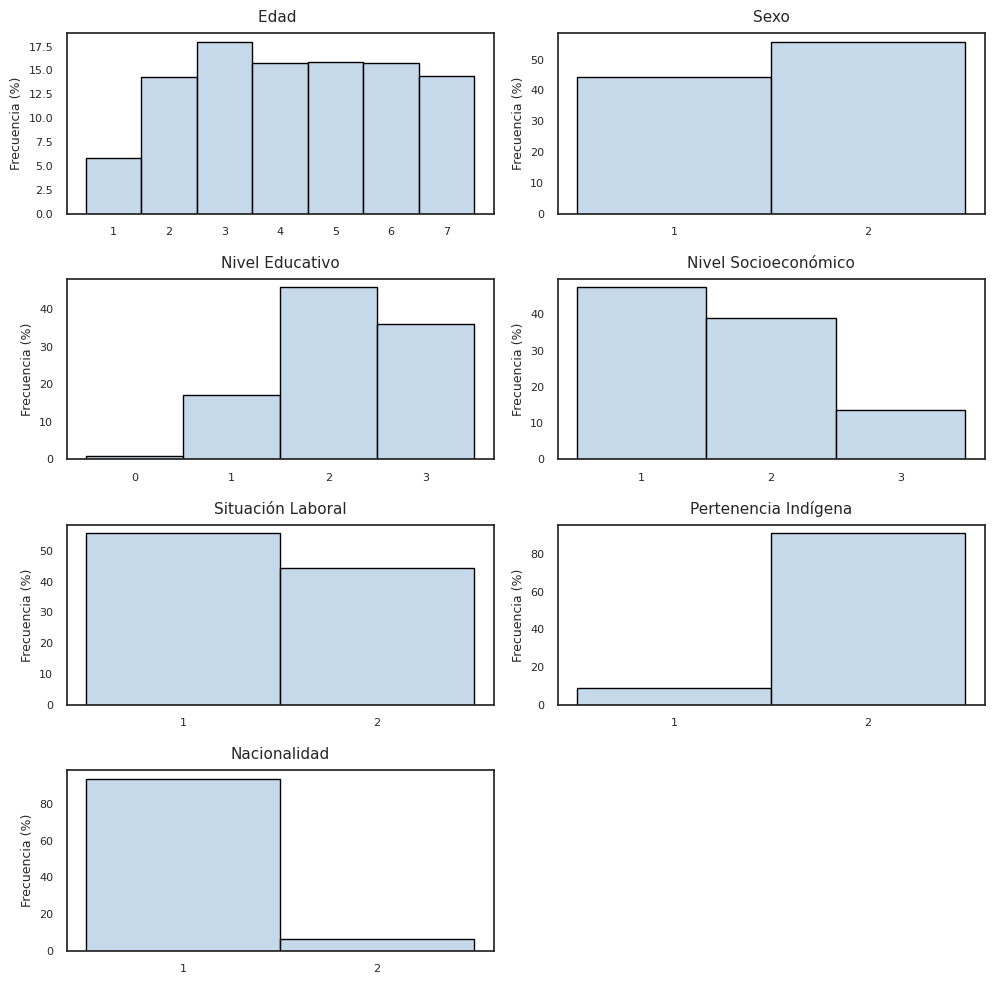

In [ ]:
# GRÁFICO DE FEATURES UNIVARIADO

# Estilo
sage  = "#B3CDE3"
black = "#000000"
sns.set_theme(style="white")
plt.rcParams.update({
    "axes.titlesize"  : 11,
    "axes.labelsize"  : 9,
    "xtick.labelsize" : 8,
    "ytick.labelsize" : 8,
    "axes.titlepad"   : 8,
})

# Diccionario de títulos
titles = {
    'rph_edad'    : 'Edad ',
    'rph_sexo'    : 'Sexo',
    'rph_nivel'   : 'Nivel Educativo',
    'rph_nse'     : 'Nivel Socioeconómico',
    'rph_situacion_laboral_a'   : 'Situación Laboral',
    'rph_pertenencia_indigena'  : 'Pertenencia Indígena',
    'rph_nacionalidad'          : 'Nacionalidad'
}

fig, axes = plt.subplots(4, 2, figsize=(10, 10))
axes = axes.flatten()

for i, (var, title) in enumerate(titles.items()):
    ax = axes[i]
    # Histograma porcentual discreto
    sns.histplot(
        df_modelo[var].dropna(),
        bins=len(df_modelo[var].unique()),
        discrete=True,
        stat='percent',
        color=sage,
        edgecolor=black,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Frecuencia (%)')
    ax.set_xticks(sorted(df_modelo[var].dropna().unique()))
    # Quitar grid
    ax.grid(False)

# Si hay un subplot sobrante, lo eliminamos
if len(titles) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

La Edad (rph_edad) se concentra en los rangos intermedios (categorías 3 y 4, es decir 25–29 y 30–39 años), con una distribución moderadamente sesgada hacia edades medias. Por otro lado, Sexo (rph_sexo): hay un predominio de mujeres (≈55 %) frente a hombres (≈45 %). Nivel educativo (rph_nivel) y estrato socioeconómico (rph_nse): cerca de la mitad de los encuestados tiene educación media (categoría 2) y nivel socioeconómico medio, con una proporción menor en los extremos (básica/alta). Situación laboral (rph_situacion_laboral_a): más de la mitad trabajó la semana previa, aunque la diferencia no es abrumadora (≈55 % vs. 45 %). Pertenencia indígena y nacionalidad muestran una mayoría muy clara de no indígenas (≈90 %) y chilenos (≈95 %), respectivamente.

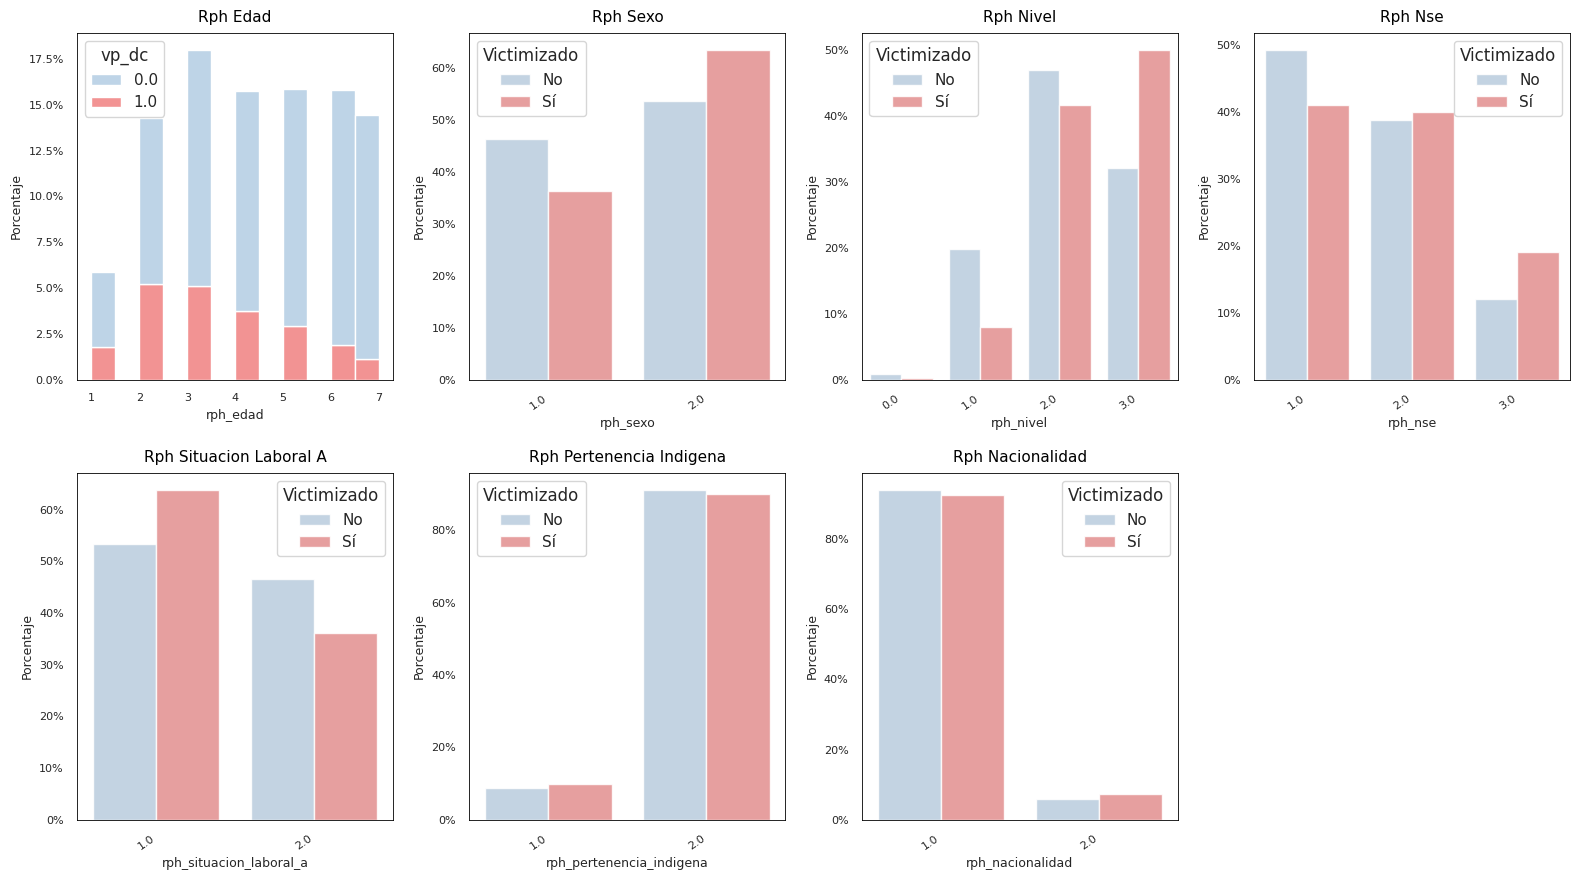

In [ ]:
# GRAFICO PARA CARACTERISTICAS PERSONALES

# Estilo
sage  = "#B3CDE3"
coral = "lightcoral"
black = "#000000"
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.titlesize": 11,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlepad": 8,
})

# Importar PercentFormatter
from matplotlib.ticker import PercentFormatter

# Diccionario de títulos
titles = {
    'rph_edad': 'Edad (rph_edad)',
    'rph_sexo': 'Sexo (rph_sexo)',
    'rph_nivel': 'Nivel Educativo (rph_nivel)',
    'rph_nse': 'Nivel Socioeconómico (rph_nse)',
    'rph_situacion_laboral_a': 'Situación Laboral (rph_situacion_laboral_a)',
    'rph_pertenencia_indigena': 'Pertenencia Indígena (rph_pertenencia_indigena)',
    'rph_nacionalidad': 'Nacionalidad (rph_nacionalidad)'
}

vars_panel = [
    "rph_edad","rph_sexo","rph_nivel","rph_nse",
    "rph_situacion_laboral_a","rph_pertenencia_indigena",
    "rph_nacionalidad"
]
num_vars = ["rph_edad"]

fig, axes = plt.subplots(2, 4, figsize=(16,9))
axes = axes.flatten()

for ax, var in zip(axes, vars_panel):
    if var in num_vars:
        # Histograma apilado en % para variables numéricas
        sns.histplot(
            data=df_modelo,
            x=var,
            hue="vp_dc",
            stat="percent",
            multiple="stack",
            bins=12,
            palette=[sage, coral],
            edgecolor="white",
            alpha=.85,
            ax=ax
        )
        ax.yaxis.set_major_formatter(PercentFormatter())
        ax.set_ylabel("Porcentaje")
        ax.set_xlabel(var)
    else:
        # Primero calculamos el % de cada categoría dentro de cada grupo vp_dc
        df_pct = (
            df_modelo
            .groupby("vp_dc")[var]
            .value_counts(normalize=True)
            .mul(100)
            .rename("pct")
            .reset_index()
        )
        # Ahora barplot con categorías en X y % en Y
        sns.barplot(
            data=df_pct,
            x=var,
            y="pct",
            hue="vp_dc",
            palette=[sage, coral],
            edgecolor="white",
            alpha=.85,
            ax=ax
        )
        ax.yaxis.set_major_formatter(PercentFormatter())
        ax.set_ylabel("Porcentaje")
        ax.set_xlabel(var)
        ax.legend_.set_title("Victimizado")
        for txt, lab in zip(ax.legend_.texts, ["No","Sí"]):
            txt.set_text(lab)
        plt.setp(ax.get_xticklabels(), rotation=35, ha="right")

    ax.set_title(var.replace("_"," ").title(), color=black)
    for spine in ax.spines.values():
        spine.set_edgecolor(black)
        spine.set_linewidth(.6)
    ax.grid(False)

# Borra ejes sobrantes
for ax in axes[len(vars_panel):]:
    fig.delaxes(ax)

plt.tight_layout(pad=1.2)
plt.show()

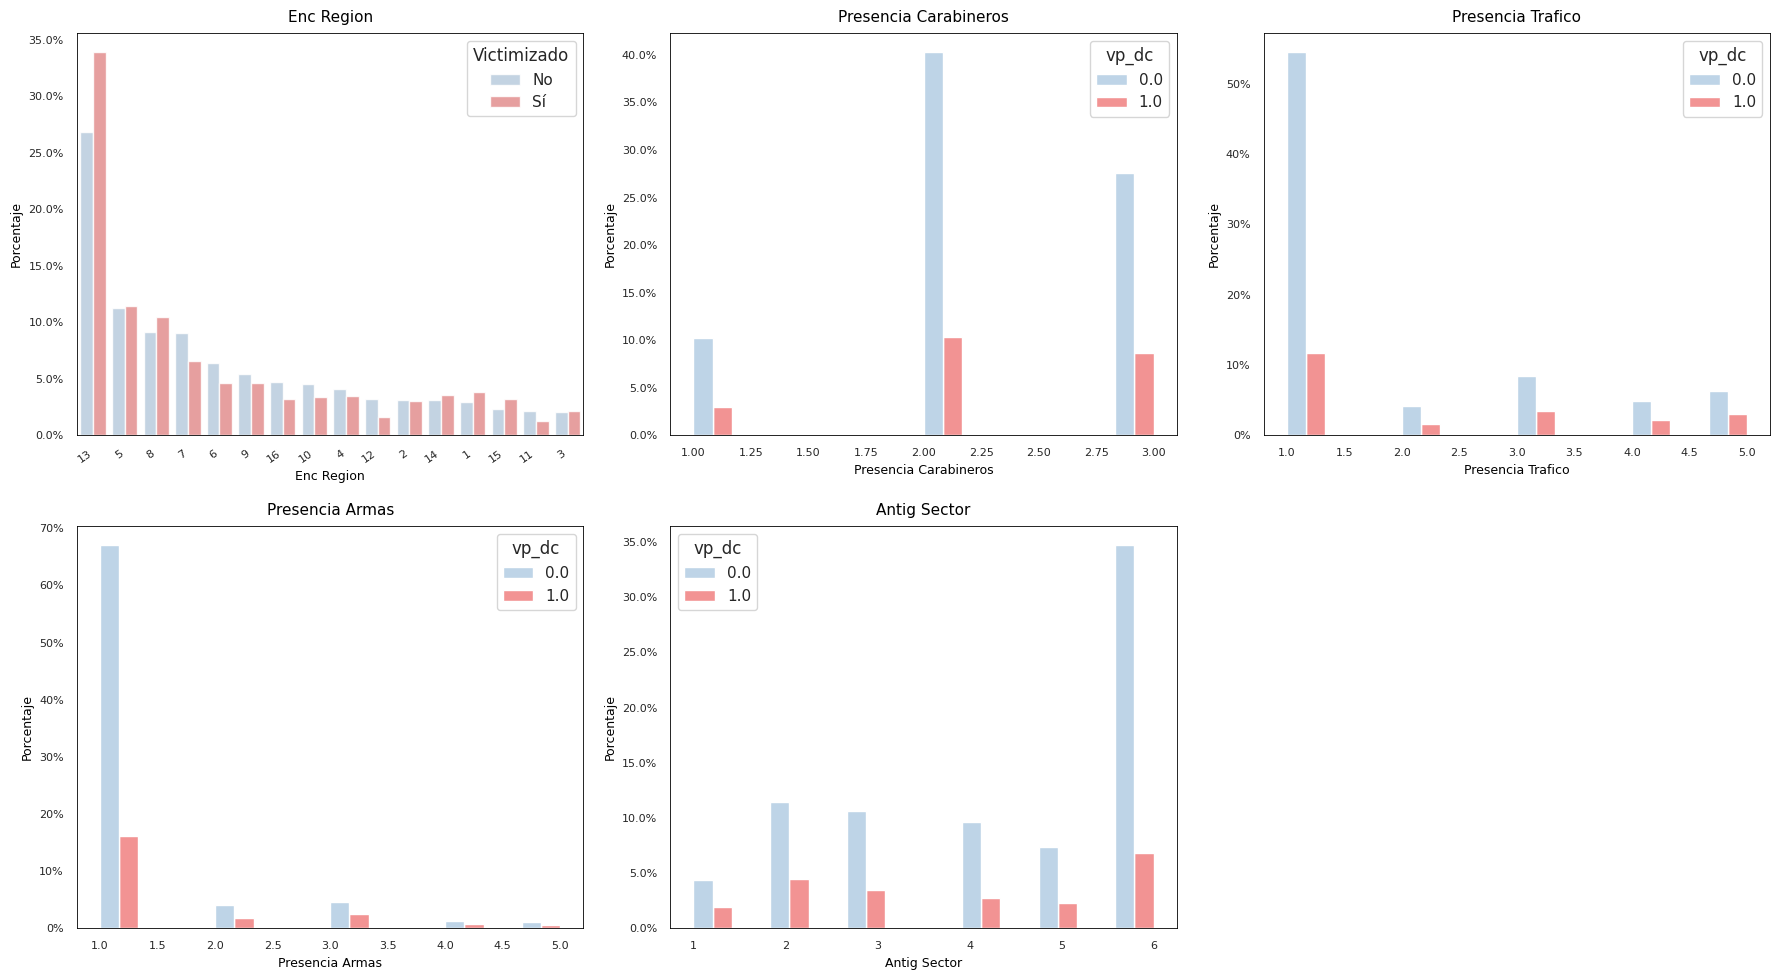

In [ ]:
# GRAFICO

# Colores y tema
sage  = "#B3CDE3"
coral = "lightcoral"
black = "#000000"
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.titlesize": 11,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlepad": 8,
})

vars_contexto = [
    "enc_region",
    "presencia_carabineros",
    "presencia_trafico",
    "presencia_armas",
    "antig_sector"
]
num_vars = [
    "presencia_carabineros",
    "presencia_trafico",
    "presencia_armas",
    "antig_sector"
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, var in zip(axes, vars_contexto):
    if var in num_vars:
        # Histograma DODGE en porcentaje
        sns.histplot(
            data=df_modelo,
            x=var,
            hue="vp_dc",
            stat="percent",
            multiple="dodge",   # <-- aquí
            bins=12,
            palette=[sage, coral],
            edgecolor="white",
            alpha=.85,
            ax=ax
        )
        ax.yaxis.set_major_formatter(PercentFormatter())
        ax.set_ylabel("Porcentaje", color=black)
        ax.set_xlabel(var.replace("_", " ").title(), color=black)
    else:
        # Barplot vertical en porcentaje (categoría vs vp_dc)
        df_pct = (
            df_modelo
            .groupby("vp_dc")[var]
            .value_counts(normalize=True)
            .mul(100)
            .rename("pct")
            .reset_index()
        )
        sns.barplot(
            data=df_pct,
            x=var,
            y="pct",
            hue="vp_dc",
            palette=[sage, coral],
            edgecolor="white",
            alpha=.85,
            ax=ax
        )
        ax.yaxis.set_major_formatter(PercentFormatter())
        ax.set_ylabel("Porcentaje", color=black)
        ax.set_xlabel(var.replace("_", " ").title(), color=black)
        ax.legend_.set_title("Victimizado")
        for txt, lab in zip(ax.legend_.texts, ["No","Sí"]):
            txt.set_text(lab)
        plt.setp(ax.get_xticklabels(), rotation=35, ha="right")

    ax.set_title(textwrap.fill(var.replace("_"," ").title(), 30), color=black)
    for spine in ax.spines.values():
        spine.set_edgecolor(black)
        spine.set_linewidth(.6)
    ax.grid(False)

# Eliminar cualquier eje sobrante
for ax in axes[len(vars_contexto):]:
    fig.delaxes(ax)

plt.tight_layout(pad=1.2)
plt.show()

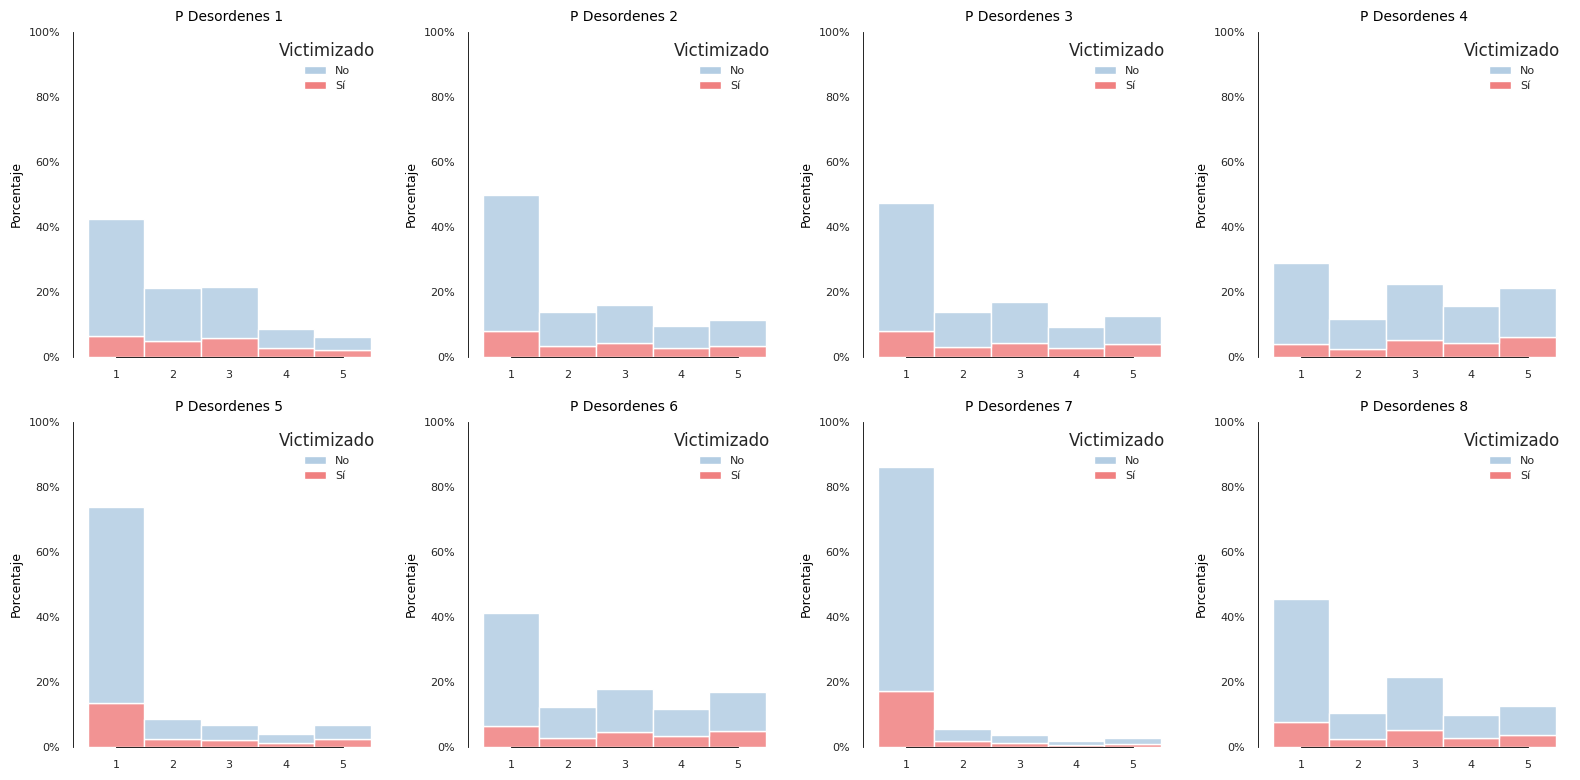

In [ ]:
# GRAFICO PARA DESORDENES

# Colores y tema
sage  = "#B3CDE3"      # No victimizado
coral = "lightcoral"   # Sí victimizado
black = "#000000"
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.titlesize": 11,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlepad": 8,
})

# Importar Patch para la leyenda manual
from matplotlib.patches import Patch

# Ítems de desórdenes
vars_desorden = [f"p_desordenes_{i}" for i in range(1, 9)]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for ax, var in zip(axes, vars_desorden):
    sns.histplot(
        data=df_modelo,
        x=var,
        hue="vp_dc",
        hue_order=[0,1],
        palette=[sage, coral],
        stat="percent",
        multiple="stack",
        discrete=True,
        bins=np.arange(1,7)-0.5,
        edgecolor="white",
        alpha=.85,
        ax=ax
    )
    # Ejes y formato
    ax.set_xticks([1,2,3,4,5])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))
    ax.yaxis.set_major_formatter(PercentFormatter())
    ax.set_ylim(0, 100)
    ax.set_xlabel("")
    ax.set_ylabel("Porcentaje", fontsize=9, color=black)
    ax.set_title(textwrap.fill(var.replace("_", " ").title(), 30),
                 fontsize=10, color=black)

    # Construir manual la leyenda para forzar labels "No" y "Sí"
    handles = [
        Patch(facecolor=sage,  edgecolor="white", label="No"),
        Patch(facecolor=coral, edgecolor="white", label="Sí")
    ]
    ax.legend(
        handles=handles,
        title="Victimizado",
        frameon=False,
        prop={"size":8}
    )

    # Estética de bordes y grid
    for spine in ax.spines.values():
        spine.set_edgecolor(black)
        spine.set_linewidth(.6)
    ax.grid(False)

# Quitar ejes sobrantes
for ax in axes[len(vars_desorden):]:
    fig.delaxes(ax)

sns.despine(trim=True)
plt.tight_layout(pad=1.2)
plt.show()

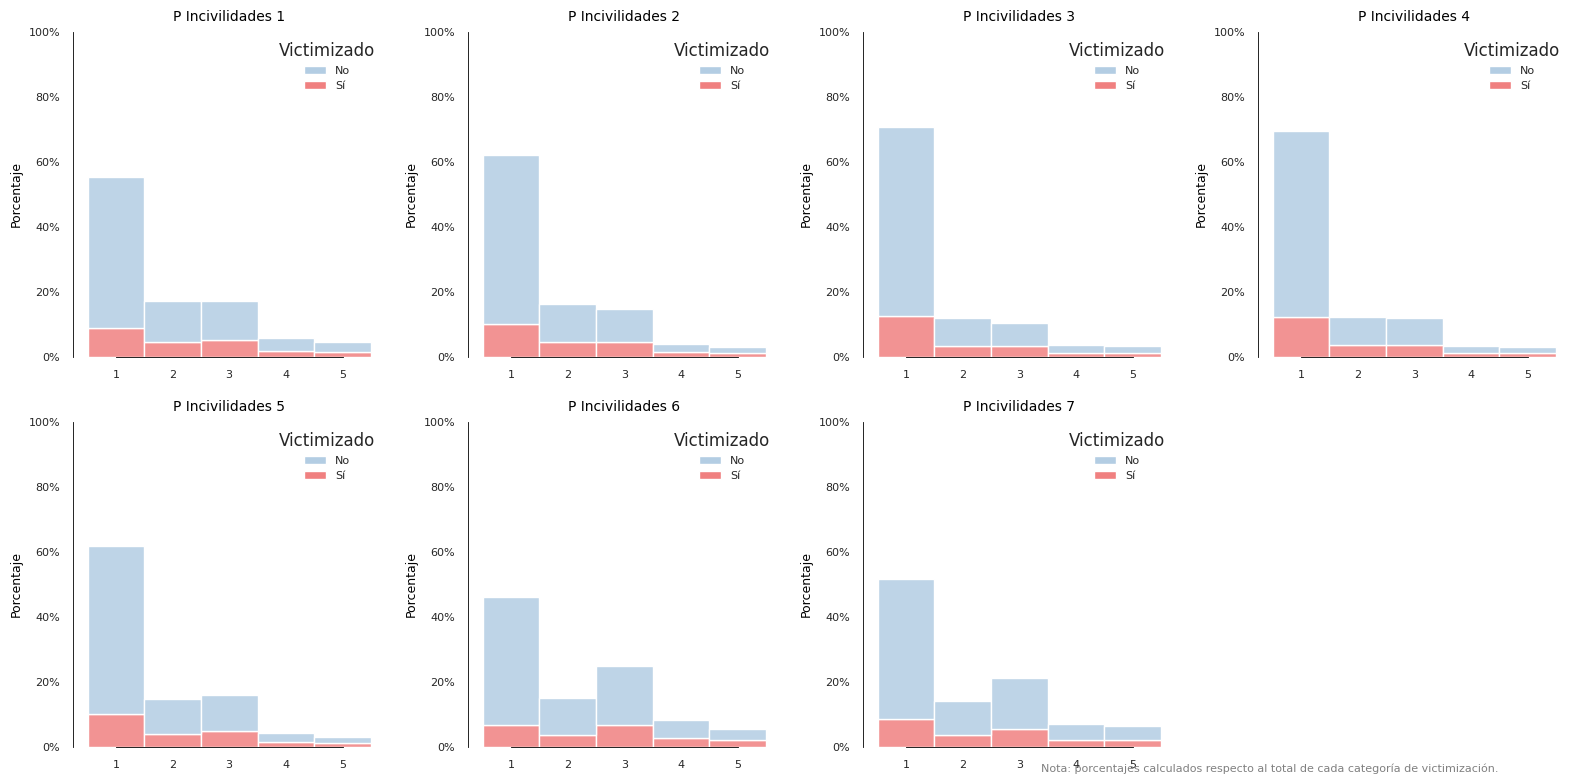

In [ ]:
# GRAFICO PARA INCIVILIDADES

# Colores y tema
sage  = "#B3CDE3"      # No victimizado
coral = "lightcoral"   # Sí victimizado
black = "#000000"
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.titlesize": 11,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlepad": 8,
})

# Ítems de incivilidades
vars_inciv = [f"p_incivilidades_{i}" for i in range(1, 8)]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for ax, var in zip(axes, vars_inciv):
    sns.histplot(
        data=df_modelo,
        x=var,
        hue="vp_dc",
        hue_order=[0, 1],
        palette=[sage, coral],
        stat="percent",        # <-- porcentaje
        multiple="stack",      # apilado
        discrete=True,
        bins=np.arange(1, 7) - 0.5,
        edgecolor="white",
        alpha=.85,
        ax=ax
    )

    # Formato de ejes
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))
    ax.yaxis.set_major_formatter(PercentFormatter())   # eje Y en %

    # Fijar eje Y de 0 a 100%
    ax.set_ylim(0, 100)

    ax.set_xlabel("")
    ax.set_ylabel("Porcentaje", fontsize=9, color=black)
    ax.set_title(textwrap.fill(var.replace("_", " ").title(), 30),
                 fontsize=10, color=black)

    # Leyenda manual
    handles = [
        Patch(facecolor=sage, edgecolor="white", label="No"),
        Patch(facecolor=coral, edgecolor="white", label="Sí")
    ]
    ax.legend(
        handles=handles,
        title="Victimizado",
        frameon=False,
        prop={"size":8}
    )

    # Estética de bordes y fondo
    for spine in ax.spines.values():
        spine.set_edgecolor(black)
        spine.set_linewidth(.6)
    ax.grid(False)

# Quitar eje sobrante si existe
for ax in axes[len(vars_inciv):]:
    fig.delaxes(ax)

sns.despine(trim=True)
plt.tight_layout(pad=1.2)

# Nota de pie centrada al fondo del lienzo
fig.text(
    0.8,      # posición X (0=izquierda, 1=derecha)
    0.02,     # posición Y (0=abajo, 1=arriba)
    "Nota: porcentajes calculados respecto al total de cada categoría de victimización.",
    ha="center", va="bottom",
    fontsize=8,
    color="gray"
)

plt.show()

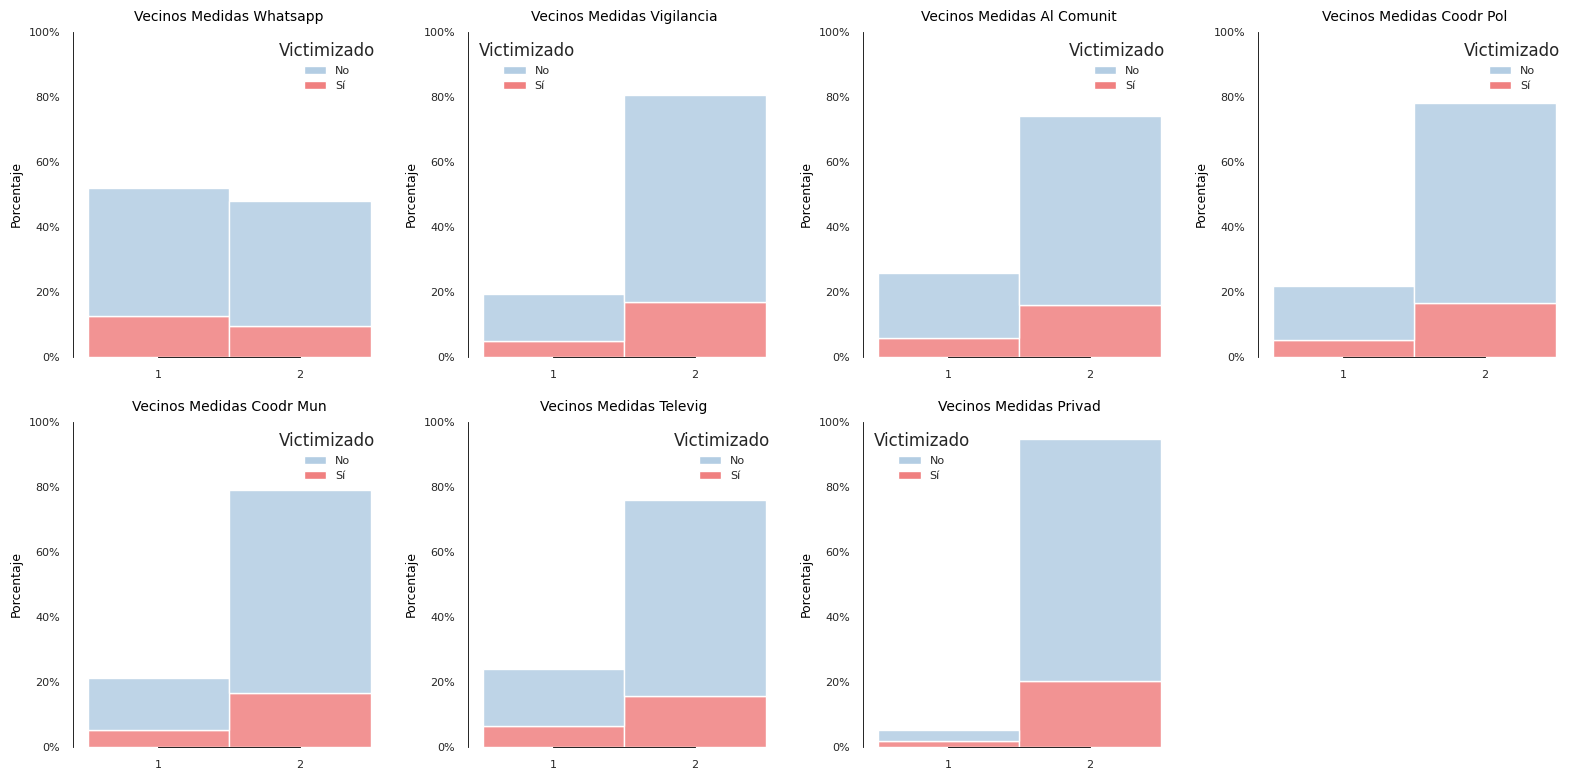

In [ ]:
# GRAFICO PARA VECINOS MEDIDAS

# Colores y tema
sage  = "#B3CDE3"      # No victimizado
coral = "lightcoral"   # Sí victimizado
black = "#000000"
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.titlesize": 11,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlepad": 8,
})

# Lista de variables de medidas comunitarias
vars_vecinos = [
    "vecinos_medidas_whatsapp",
    "vecinos_medidas_vigilancia",
    "vecinos_medidas_al_comunit",
    "vecinos_medidas_coodr_pol",
    "vecinos_medidas_coodr_mun",
    "vecinos_medidas_televig",
    "vecinos_medidas_privad"
]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for ax, var in zip(axes, vars_vecinos):
    # Histograma apilado en porcentaje
    sns.histplot(
        data=df_modelo,
        x=var,
        hue="vp_dc",
        hue_order=[0, 1],
        palette=[sage, coral],
        stat="percent",        # muestra porcentaje
        multiple="stack",      # apilado
        discrete=True,
        edgecolor="white",
        alpha=.85,
        ax=ax
    )
    # Ajustes de ejes
    ticks = sorted(df_modelo[var].dropna().unique())
    ax.set_xticks(ticks)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))
    ax.yaxis.set_major_formatter(PercentFormatter())   # eje Y en %
    ax.set_ylim(0, 100)                                # 0 a 100%

    # Etiquetas y título
    ax.set_xlabel("")
    ax.set_ylabel("Porcentaje", fontsize=9, color=black)
    ax.set_title(textwrap.fill(var.replace("_", " ").title(), 30),
                 fontsize=10, color=black)

    # Leyenda manual
    handles = [
        Patch(facecolor=sage,  edgecolor="white", label="No"),
        Patch(facecolor=coral, edgecolor="white", label="Sí")
    ]
    ax.legend(
        handles=handles,
        title="Victimizado",
        frameon=False,
        prop={"size":8}
    )

    # Estética de bordes y fondo
    for spine in ax.spines.values():
        spine.set_edgecolor(black)
        spine.set_linewidth(.6)
    ax.grid(False)

# Quitar eje sobrante
for ax in axes[len(vars_vecinos):]:
    fig.delaxes(ax)

sns.despine(trim=True)
plt.tight_layout(pad=1.2)
plt.show()

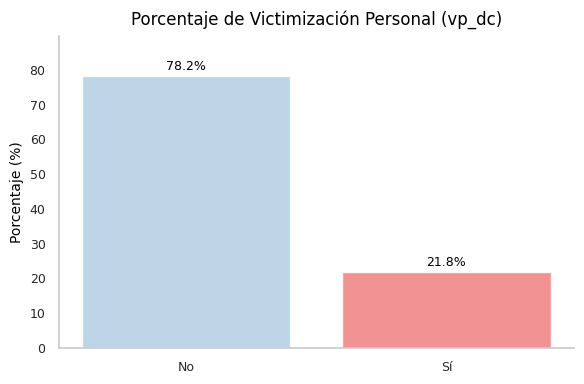

In [ ]:
# GRAFICO PARA TARGET

pct = df_modelo['vp_dc'].value_counts(normalize=True).sort_index() * 100
labels = ['No', 'Sí']

# Colores y tema
sage  = "#B3CDE3"      # No victimizado
coral = "lightcoral"   # Sí victimizado
black = "#000000"
plt.rcParams.update({
    "axes.titlesize" : 12,
    "axes.labelsize" : 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# Gráfico de barras de porcentaje con Matplotlib
fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(
    labels,
    pct.values,
    color=[sage, coral],
    edgecolor="white",
    alpha=.85
)

# Etiquetas de porcentaje encima de cada barra
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        f"{height:.1f}%",
        ha="center", va="bottom",
        color=black,
        fontsize=9
    )

# Ajustes finales
ax.set_xlabel("")
ax.set_ylabel("Porcentaje (%)", color=black)
ax.set_title("Porcentaje de Victimización Personal (vp_dc)", color=black)
ax.set_ylim(0, pct.max() * 1.15)

# Quitar fondo de rejilla y spines innecesarios
ax.grid(False)
for spine in ["top","right","left","bottom"]:
    ax.spines[spine].set_visible(spine in ["left","bottom"])

plt.tight_layout()
plt.show()

Cramér's V (Región vs Victimización): 0.102


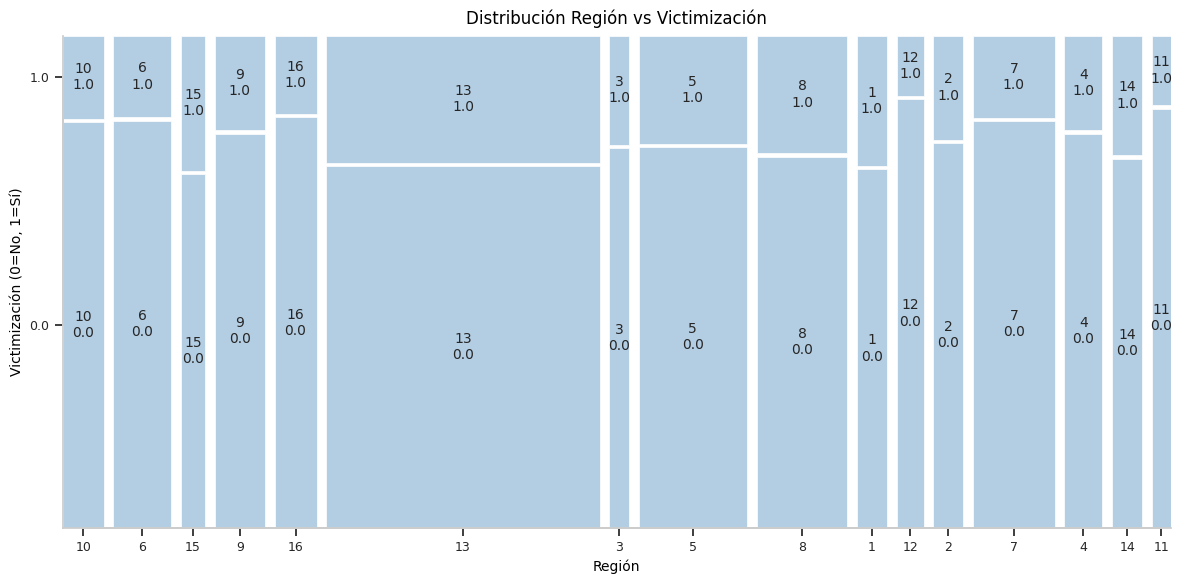

In [ ]:
# Colores y tema
sage  = "#B3CDE3"      # No victimizado
coral = "lightcoral"   # Sí victimizado
black = "#000000"
plt.rcParams.update({
    "axes.titlesize" : 12,
    "axes.labelsize" : 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# 1. Cálculo de Cramér's V
cm = pd.crosstab(df_modelo['enc_region'], df_modelo['vp_dc'])
chi2, _, _, _ = chi2_contingency(cm)
n = cm.values.sum()
phi2 = chi2 / n
r, k = cm.shape
cramer_v = np.sqrt(phi2 / min(k-1, r-1))
print(f"Cramér's V (Región vs Victimización): {cramer_v:.3f}")

# 2. Mosaic plot con facecolor
def props(key):
    return {
        'facecolor': coral if key[1] == 1 else sage,
        'edgecolor': 'white',
        'linewidth': 0.5
    }

fig, ax = plt.subplots(figsize=(12, 6))
mosaic(
    df_modelo,
    ['enc_region', 'vp_dc'],
    properties=props,
    gap=0.01,
    ax=ax
)

ax.set_title("Distribución Región vs Victimización", color=black)
ax.set_xlabel("Región", color=black)
ax.set_ylabel("Victimización (0=No, 1=Sí)", color=black)

# Quitar grid y despine
ax.grid(False)
sns.despine(trim=True)

plt.tight_layout()
plt.show()

In [ ]:
# CORRELACIÓN y asociación con variable target

# Función V de Cramér
def cramers_v(x, y):
    cm = pd.crosstab(x, y)
    chi2 = chi2_contingency(cm)[0]
    n = cm.values.sum()
    phi2 = chi2 / n
    r, k = cm.shape
    return np.sqrt(phi2 / min(k-1, r-1))

# 1) Variables categóricas
cat_vars = [
    "rph_sexo","rph_nivel","rph_nse","rph_situacion_laboral_a",
    "rph_pertenencia_indigena","rph_nacionalidad",
    "enc_region", "presencia_carabineros","presencia_trafico",
    "presencia_armas"
]
biv_cat = []
for v in cat_vars:
    ct = pd.crosstab(df_modelo[v], df_modelo["vp_dc"])
    chi2, p, _, _ = chi2_contingency(ct)
    cr = cramers_v(df_modelo[v], df_modelo["vp_dc"])
    biv_cat.append({
        "variable": v,
        "chi2":    chi2,
        "p_valor": p,
        "CramersV": cr
    })
biv_cat = pd.DataFrame(biv_cat).sort_values("CramersV", ascending=False)
print("### Asociaciones Categóricas vs vp_dc")
print(biv_cat.to_markdown(index=False, floatfmt=".3f"))


# 2) Variables numéricas
num_vars = [
    "antig_sector",
    "ev_confia_cch"
]
biv_num = []
for v in num_vars:
    grp0 = df_modelo.loc[df_modelo["vp_dc"]==0, v].dropna()
    grp1 = df_modelo.loc[df_modelo["vp_dc"]==1, v].dropna()
    # puedes cambiar a mannwhitneyu si no asumes normalidad
    stat, p = ttest_ind(grp0, grp1, equal_var=False)
    biv_num.append({
        "variable": v,
        "media_no": grp0.mean(),
        "media_si": grp1.mean(),
        "t_stat":   stat,
        "p_valor":  p
    })
    # Also print t-test results for each variable
    print(f"\nT-test for {v}: t_stat={stat:.3f}, p_valor={p:.3f}")

biv_num = pd.DataFrame(biv_num).sort_values("p_valor")
print("\n### Diferencia de medias (T-test) Numéricas vs vp_dc")
print(biv_num.to_markdown(index=False, floatfmt=".3f"))

### Asociaciones Categóricas vs vp_dc
| variable                 |     chi2 |   p_valor |   CramersV |
|:-------------------------|---------:|----------:|-----------:|
| rph_nivel                | 1544.779 |     0.000 |      0.177 |
| presencia_trafico        | 1056.139 |     0.000 |      0.147 |
| presencia_armas          |  854.480 |     0.000 |      0.131 |
| enc_region               |  516.051 |     0.000 |      0.102 |
| rph_nse                  |  431.502 |     0.000 |      0.093 |
| rph_situacion_laboral_a  |  376.530 |     0.000 |      0.087 |
| rph_sexo                 |  341.375 |     0.000 |      0.083 |
| presencia_carabineros    |   72.356 |     0.000 |      0.039 |
| rph_nacionalidad         |   29.482 |     0.000 |      0.024 |
| rph_pertenencia_indigena |   14.642 |     0.000 |      0.017 |

T-test for antig_sector: t_stat=25.704, p_valor=0.000

T-test for ev_confia_cch: t_stat=-18.992, p_valor=0.000

### Diferencia de medias (T-test) Numéricas vs vp_dc
| variable      

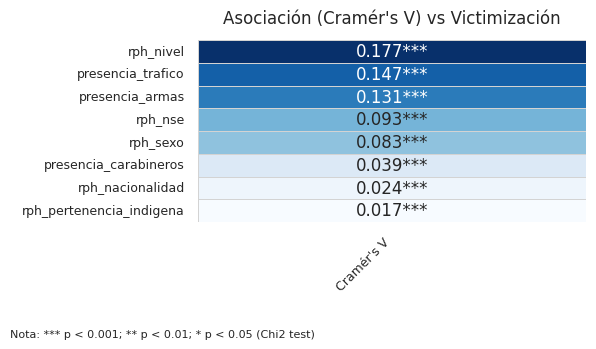

In [ ]:
# Diseño y tema
sage  = "#B3CDE3"      # No victimizado
coral = "lightcoral"   # Sí victimizado
black = "#000000"
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.titlesize" : 12,
    "axes.labelsize" : 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# Función V de Cramér
def cramers_v(x, y):
    cm   = pd.crosstab(x, y)
    chi2 = chi2_contingency(cm)[0]
    n    = cm.values.sum()
    phi2 = chi2 / n
    r, k = cm.shape
    return np.sqrt(phi2 / min(k-1, r-1))

# Calcular Cramér's V y p-valores
# Sacamos regiones y lo estudiamos anteriormente porque nos gustaria ver como se comporta por cada región.
cat_vars = [
    "rph_sexo","rph_nivel","rph_nse",
    "rph_pertenencia_indigena","rph_nacionalidad",
    "presencia_carabineros","presencia_trafico",
    "presencia_armas"
]

biv_cat = []
for v in cat_vars:
    cm      = pd.crosstab(df_modelo[v], df_modelo["vp_dc"])
    chi2, p = chi2_contingency(cm)[:2]
    cr      = cramers_v(df_modelo[v], df_modelo["vp_dc"])
    # Estrellas de significancia
    if p < 0.001:
        sig = "***"
    elif p < 0.01:
        sig = "**"
    elif p < 0.05:
        sig = "*"
    else:
        sig = ""
    biv_cat.append({
        "Variable":    v,
        "Cramér's V":  round(cr, 3),
        "sig":         sig
    })

df_cramer = pd.DataFrame(biv_cat).sort_values("Cramér's V", ascending=False)

# Preparar matriz y anotaciones
mat = df_cramer.set_index("Variable")[["Cramér's V"]]
annot = (df_cramer["Cramér's V"].astype(str) + df_cramer["sig"])\
        .values.reshape(-1, 1)

#  Plot heatmap
fig, ax = plt.subplots(figsize=(6, mat.shape[0]*0.4))
sns.heatmap(
    mat,
    annot=annot,
    fmt="",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="lightgray",
    ax=ax
)

ax.set_title("Asociación (Cramér's V) vs Victimización", pad=12)
ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# === Nota de significancia ===
fig.subplots_adjust(bottom=0.2)
fig.text(
    0.01, -0.08,
    "Nota: *** p < 0.001; ** p < 0.01; * p < 0.05 (Chi2 test)",
    ha="left",
    fontsize=8
)

plt.tight_layout()
plt.show()

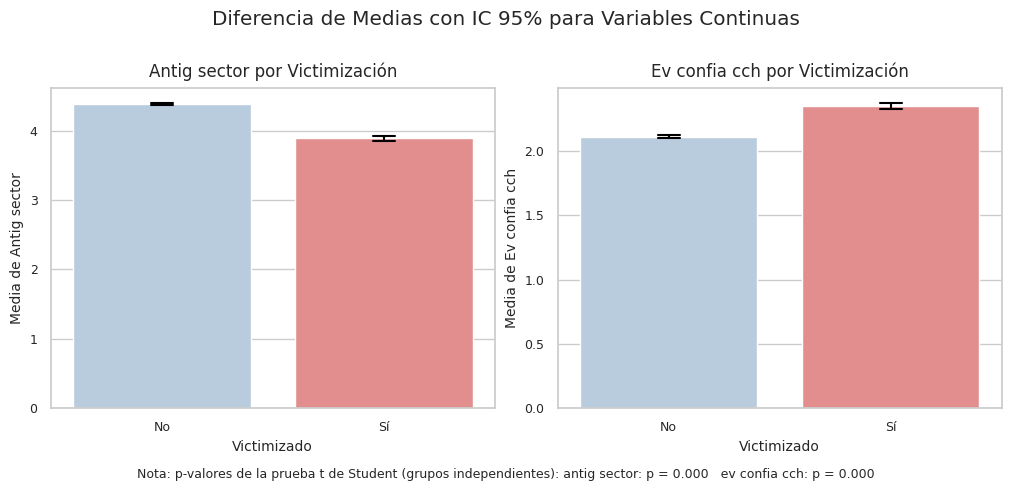

In [ ]:
# Tema y colores
sage  = "#B3CDE3"      # Color para grupo No victimizado
coral = "lightcoral"   # Color para grupo Sí victimizado
black = "#000000"
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.titlesize" : 12,
    "axes.labelsize" : 10,
    "xtick.labelsize":  9,
    "ytick.labelsize":  9,
})

# Variables numéricas ===
num_vars = ["antig_sector", "ev_confia_cch"]

# Calcular t-test y almacenar p-valores ===
biv_num = []
for v in num_vars:
    grp0 = df_modelo.loc[df_modelo["vp_dc"] == 0, v].dropna()
    grp1 = df_modelo.loc[df_modelo["vp_dc"] == 1, v].dropna()
    stat, p = ttest_ind(grp0, grp1, equal_var=False)
    biv_num.append({
        "Variable": v,
        "p_valor": p
    })
df_ttest = pd.DataFrame(biv_num)

# Crear figure y subplots ===
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(num_vars),
    figsize=(5 * len(num_vars), 4),
    constrained_layout=True
)
if len(num_vars) == 1:
    axes = [axes]

# Graficar medias con IC 95%
for ax, v in zip(axes, num_vars):
    sns.barplot(
        x="vp_dc",
        y=v,
        data=df_modelo,
        palette=[sage, coral],
        ci=95,
        capsize=0.1,
        errcolor=black,
        errwidth=1.5,
        ax=ax
    )
    ax.set_xticklabels(["No", "Sí"])
    ax.set_xlabel("Victimizado")
    ax.set_ylabel(f"Media de {v.replace('_', ' ').capitalize()}")
    ax.set_title(f"{v.replace('_', ' ').capitalize()} por Victimización")

# Título con mayor separación
plt.suptitle("Diferencia de Medias con IC 95% para Variables Continuas", y=1.12)

# Nota de significancia abajo
p_texts = [f"{row['Variable'].replace('_', ' ')}: p = {row['p_valor']:.3f}"
           for _, row in df_ttest.iterrows()]
nota = "   ".join(p_texts)
fig.subplots_adjust(bottom=0.2, top=0.85)
fig.text(
    0.5,  -0.05,
    f"Nota: p-valores de la prueba t de Student (grupos independientes): {nota}",
    ha="center",
    fontsize=9
)

plt.show()

 #### **Preprocessing inicial: estandarización y limpieza de datos**

* El preprocessing inicia con la **tipificación explícita** de variables según su naturaleza (binarias vs categóricas), facilitando el manejo diferenciado durante transformaciones posteriores. Esta clasificación permite aplicar estrategias de encoding específicas: mapeo 0/1 para binarias y dummy encoding para categóricas, optimizando la ingesta por algoritmos de ML.

* Los **códigos especiales ENUSC** (88="No sabe", 96="No aplica", 99="No responde") se convierten a `NaN` para tratamiento sistemático como missing values. Esta estandarización previene que algoritmos de ML interpreten estos códigos como valores numéricos válidos, evitando introducir ruido artificial en el modelo. La conversión permite posterior aplicación de técnicas de imputación apropiadas.

* La **conversión a enteros** (excluyendo factores de ponderación) estandariza el formato numérico, reduciendo memoria y mejorando eficiencia computacional. Variables binarias se mapean automáticamente a **codificación 0/1**, donde 0 representa la categoría de menor valor ordinal y 1 la mayor, siguiendo convenciones estándar de ML para interpretabilidad de coeficientes y probabilidades.

* El **análisis sistemático de datos perdidos** identifica variables problemáticas (>5% missings) que requieren estrategias de imputación específicas. Este diagnóstico informa decisiones de preprocessing: variables con alta tasa de missings pueden requerir técnicas sofisticadas de imputación o consideración para exclusión si comprometen representatividad muestral. El reporte cuantificado facilita decisiones metodológicas informadas sobre trade-offs entre completitud de datos y tamaño muestral efectivo.

In [ ]:
# 1. CONFIGURACIÓN Y LIMPIEZA

# Variables por tipo
BINARIAS    = ['vp_dc', 'rph_sexo', 'rph_situacion_laboral_a']
CATEGORICAS = ['rph_edad', 'rph_nivel', 'rph_nse', 'rph_disc_a', 'rph_disc_b']

# Reemplazar códigos de "no sabe/no responde" con NaN
df_modelo = df_modelo.replace({88: np.nan, 96: np.nan, 99: np.nan})

# Convertir TODA la base a enteros, excepto fact_pers_com y fact_pers_reg
for col in df_modelo.columns:
    # Excluir variables que contengan "fact_pers_com" o "fact_pers_reg"
    if 'fact_pers_com' in col or 'fact_pers_reg' in col:
        continue

    # Solo procesar columnas numéricas
    if df_modelo[col].dtype in ['float64', 'float32', 'int64', 'int32']:
        # Convertir a entero sin decimales
        df_modelo[col] = pd.to_numeric(df_modelo[col], errors='coerce').round().astype('Int64')

    # Para variables binarias, mapear a 0/1
    if col in BINARIAS and col in df_modelo.columns:
        valores = df_modelo[col].dropna().unique()
        if len(valores) == 2:
            valor_min, valor_max = sorted(valores)
            df_modelo[col] = df_modelo[col].map({valor_min: 0, valor_max: 1}).astype('Int64')

# 2. ANÁLISIS DE DATOS PERDIDOS

# Ver cuántos valores perdidos hay por variable
valores_perdidos    = df_modelo.isnull().sum()
porcentaje_perdidos = (valores_perdidos / len(df_modelo) * 100).round(1)

print("Variables con más valores perdidos:")
for var in porcentaje_perdidos[porcentaje_perdidos > 5].head(10).index:
    print(f"  {var}: {porcentaje_perdidos[var]}%")
df_modelo

Variables con más valores perdidos:
  ev_confia_cch: 36.9%
  p_desordenes_5: 10.1%
  p_desordenes_7: 6.2%
  vecinos_medidas_coodr_pol: 17.9%
  vecinos_medidas_coodr_mun: 19.0%


,rph_edad,rph_sexo,rph_nivel,rph_nse,rph_situacion_laboral_a,rph_pertenencia_indigena,rph_nacionalidad,enc_region,presencia_carabineros,presencia_trafico,...,rph_disc_f,p_acciones_vecinos_1,p_acciones_vecinos_2,p_acciones_vecinos_3,p_acciones_vecinos_4,p_acciones_vecinos_5,antig_sector,vp_dc,fact_pers_com,fact_pers_reg
0,5,1,2,1,1,2,1,10,3,1,...,1,2,2,3,2,3,6,0,425.245263,519.894835
5,4,0,3,3,0,2,2,10,2,1,...,1,2,4,3,3,3,2,0,111.786565,191.978862
8,6,1,1,1,1,2,1,6,1,1,...,1,2,2,4,1,4,6,0,153.059839,184.123350
10,7,0,2,3,1,2,1,15,1,1,...,1,2,2,3,3,<NA>,5,0,131.271186,116.179779
12,6,1,2,1,0,2,1,9,3,1,...,1,4,2,2,1,3,3,1,389.411700,454.339651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146280,6,0,3,3,0,<NA>,1,16,2,1,...,1,1,2,3,3,2,4,1,32.558375,35.790626
146283,2,1,2,1,1,2,1,5,3,4,...,1,1,3,4,4,4,5,1,116.992970,147.842076
146285,2,1,2,1,1,2,2,15,<NA>,1,...,1,1,2,3,1,3,1,1,114.825512,120.440185
146290,2,0,3,1,1,2,1,8,2,2,...,1,2,2,3,3,3,4,0,129.808159,160.192941


## 3. Feature Engineering <a name="seccion3"></a>
Incluir en esta sección:
- Transformaciones necesarias tanto de atributos como target para su ingesta por parte de algoritmos ML:
    - Estandarización y escalado
    - Bucketization
    - One-hot encoding
    - Técnicas de reducción de dimensionalidad

### **Construcción de Índices compuestos: Feature engineering psicométrico**

* La **construcción de índices compuestos** transforma múltiples ítems correlacionados en variables sintéticas que capturan constructos latentes teóricamente relevantes. Esta agregación reduce dimensionalidad controlando multicolinealidad entre ítems individuales, mientras preserva información conceptual esencial. Los índices proporcionan medidas más robustas y estables que ítems individuales, especialmente importante para variables perceptuales propensas a measurement error en survey data.

* Cada índice se **valida mediante Cronbach's Alpha**, evaluando consistencia interna entre ítems que supuestamente miden el mismo constructo. Valores α>0.70 indican confiabilidad aceptable, mientras α>0.80 sugiere alta consistencia. Esta validación asegura que los índices representan dimensiones coherentes y no agregaciones arbitrarias de variables, fundamentando su interpretabilidad teórica y predictiva.

* La construcción implementa **estandarización dual**: primero se normalizan individualmente los ítems componentes (media=0, SD=1) para asegurar contribución equitativa independiente de escalas originales, luego se promedian para crear el índice raw. **Segunda estandarización** del índice final garantiza comparabilidad entre índices y facilita interpretación de efectos en modelos posteriores. Este proceso produce índices con distribución normal estándar optimizada para algoritmos de ML.

* La **imputación previa** mediante mediana preserva distribuciones centrales sin introducir variabilidad artificial antes del cálculo de índices. Para variables de discapacidad se aplica **mapeo especial** (1→0, 2→1, 3→2, 4→3) normalizando escalas ordinales a formato numérico continuo. Esta estrategia diferenciada reconoce que distintos constructos requieren preprocessing específico para capturar adecuadamente su naturaleza conceptual.

* El proceso genera **cuatro índices psicométricamente validados**: Index Desorden Barrial (8 ítems), Index Incivilidades (7 ítems), Index Acciones Vecinales (5 ítems), e Index Discapacidad (6 ítems). Estos constructos sintéticos reducen 26 variables originales a 4 features interpretables, facilitando modeling eficiente mientras preservando información teóricamente relevante sobre percepción territorial, participación comunitaria y vulnerabilidad funcional.

In [ ]:
# 3. CREAR TODOS LOS ÍNDICES

# Definir todos los grupos de ítems
grupos_indices = {
    'index_desorden'        : [f"p_desordenes_{i}" for i in range(1, 9)],
    'index_incivil'         : [f"p_incivilidades_{i}" for i in range(1, 8)],
    'index_acciones_vecinos': [f"p_acciones_vecinos_{i}" for i in range(1, 6)],
    'index_discapacidad'    : ['rph_disc_a', 'rph_disc_b', 'rph_disc_c', 'rph_disc_d', 'rph_disc_e', 'rph_disc_f']
}

# Mapeo especial para variables de discapacidad (si son numéricas)
mapeo_discapacidad = {1: 0, 2: 1, 3: 2, 4: 3}

# Procesar cada grupo de índices
for nombre_indice, items in grupos_indices.items():
    print(f"\n--- Creando {nombre_indice} ---")

    # Ver qué ítems están disponibles
    items_disponibles = [item for item in items if item in df_modelo.columns]
    print(f"Ítems disponibles: {len(items_disponibles)}")

    if len(items_disponibles) >= 2:
        # Extraer datos
        datos = df_modelo[items_disponibles].copy()

        # Mapeo especial para discapacidad
        if nombre_indice == 'index_discapacidad':
            for col in items_disponibles:
                datos[col] = datos[col].map(mapeo_discapacidad)

        # Imputar valores perdidos
        imputer = SimpleImputer(strategy='median')
        datos_imputados = pd.DataFrame(
            imputer.fit_transform(datos),
            columns=items_disponibles,
            index=datos.index
        )

        # Cronbach's alpha simplificado
        k = len(items_disponibles)
        var_items = datos_imputados.var(axis=0).sum()
        var_total = datos_imputados.sum(axis=1).var()
        alpha = (k / (k - 1)) * (1 - var_items / var_total) if var_total > 0 else 0.0
        alpha = max(0.0, alpha)

        print(f"Alpha de Cronbach: {alpha:.3f}")

        # Crear índice: estandarizar ítems y promediar
        scaler = StandardScaler()
        items_estandarizados = scaler.fit_transform(datos_imputados)
        indice = np.mean(items_estandarizados, axis=1)

        # Estandarizar índice final
        scaler_final = StandardScaler()
        df_modelo[nombre_indice] = scaler_final.fit_transform(indice.reshape(-1, 1)).flatten()

        print(f"Índice creado - Media: {df_modelo[nombre_indice].mean():.3f}")
    else:
        print(f"Insuficientes ítems para crear {nombre_indice}")

# Ver los nuevos índices creados
indices_creados = [col for col in df_modelo.columns if col.startswith('index_')]
print(f"\nÍndices creados: {indices_creados}")

# Mostrar estadísticas descriptivas
if indices_creados:
    print("\nEstadísticas de los índices:")
    print(df_modelo[indices_creados].describe().round(3))


--- Creando index_desorden ---
Ítems disponibles: 8
Alpha de Cronbach: 0.807
Índice creado - Media: 0.000

--- Creando index_incivil ---
Ítems disponibles: 7
Alpha de Cronbach: 0.874
Índice creado - Media: 0.000

--- Creando index_acciones_vecinos ---
Ítems disponibles: 5
Alpha de Cronbach: 0.498
Índice creado - Media: 0.000

--- Creando index_discapacidad ---
Ítems disponibles: 6
Alpha de Cronbach: 0.646
Índice creado - Media: -0.000

Índices creados: ['index_desorden', 'index_incivil', 'index_acciones_vecinos', 'index_discapacidad']

Estadísticas de los índices:
       index_desorden  index_incivil  index_acciones_vecinos  \
count       49813.000      49813.000               49813.000   
mean            0.000          0.000                   0.000   
std             1.000          1.000                   1.000   
min            -1.270         -0.922                  -0.483   
25%            -0.759         -0.769                  -0.247   
50%            -0.200         -0.315        

### **Preprocesamiento de features no-índice: encoding y transformaciones**

El preprocesamiento implementa **estrategias específicas** según la naturaleza de cada variable, reconociendo que variables binarias, categóricas ordinales y nominales requieren transformaciones distintas para optimizar ingesta por algoritmos de ML. Esta diferenciación evita pérdida de información semántica y asegura representación adecuada de relaciones no-lineales entre categorías.

Las **variables binarias** se procesan mediante imputación con moda para preservar proporciones muestrales originales sin introducir sesgo hacia ninguna categoría. La conversión 0/1 facilita interpretación directa de coeficientes como log-odds ratios en modelos lineales y probabilidades en modelos tree-based. Variables como sexo, situación laboral y pertenencia étnica mantienen su interpretación natural tras esta transformación.

Variables categóricas con **≤5 categorías** se transforman a dummy variables con `drop_first=True` para prevenir multicolinealidad perfecta, generando k-1 variables binarias para k categorías. Esta estrategia captura relaciones no-lineales entre categorías que modelos lineales no podrían detectar con encoding ordinal. Variables con >5 categorías se mantienen categóricas para posterior procesamiento específico según algoritmo seleccionado.

La **verificación sistemática** confirma que todas las transformaciones se completaron exitosamente: variables binarias sin missings, categóricas con tipos apropiados, y dummy variables creadas correctamente. Este control de calidad previene errores silenciosos que podrían comprometer entrenamiento del modelo. El reporte final de tipos de datos asegura compatibilidad con pipeline de ML downstream y facilita debugging de problemas de formato.

El procesamiento produce un dataset optimizado donde **variables binarias están limpias** (0/1), **categóricas de baja cardinalidad se expanden** a dummies interpretables, y **variables de alta cardinalidad se preservan** para encoding algoritmo-específico. Esta preparación equilibra preservación de información con eficiencia computacional, resultando en features apropiados para entrenamiento robusto de modelos de clasificación.

In [ ]:
# 4. PREPROCESAMIENTO DE VARIABLES NO-ÍNDICE

# Definir grupos de variables para procesamiento
variables_binarias = ['vp_dc', 'rph_sexo', 'rph_situacion_laboral_a',
 'rph_pertenencia_indigena', 'rph_nacionalidad']

variables_categoricas = ['rph_edad', 'antig_sector','rph_nivel', 'rph_nse','presencia_carabineros',
  'presencia_trafico', 'presencia_armas','ev_confia_cch']

# Variables que van a dummies siempre (independiente del número de categorías)
variables_dummy_forzadas = []

print("=== PREPROCESAMIENTO DE VARIABLES NO-ÍNDICE ===")

# PASO 4.1: LIMPIAR VARIABLES BINARIAS (ya están como 0/1)

print("\n--- Variables Binarias ---")
for var in variables_binarias:
    if var in df_modelo.columns:
        # Imputar valores perdidos con la moda (valor más frecuente)
        moda = df_modelo[var].mode().iloc[0] if not df_modelo[var].mode().empty else 0
        df_modelo[var] = df_modelo[var].fillna(moda)
        print(f"{var}: {df_modelo[var].value_counts().to_dict()}")

# PASO 4.2: PROCESAR VARIABLES CATEGÓRICAS

print("\n--- Variables Categóricas ---")
for var in variables_categoricas:
    if var in df_modelo.columns:
        # Imputar valores perdidos con la moda
        moda = df_modelo[var].mode().iloc[0] if not df_modelo[var].mode().empty else 1
        df_modelo[var] = df_modelo[var].fillna(moda)

        # Convertir a categórica
        df_modelo[var] = df_modelo[var].astype('category')

        print(f"{var}: {len(df_modelo[var].cat.categories)} categorías")
        print(f"  Distribución: {dict(df_modelo[var].value_counts().head(3))}")


# PASO 4.3: CREAR VARIABLES DUMMY

print("\n--- Creando Variables Dummy ---")

# Procesar variables que van a dummy forzadamente (edad y antigüedad sector)
for var in variables_dummy_forzadas:
    if var in df_modelo.columns:
        # Imputar valores perdidos con la moda
        moda = df_modelo[var].mode().iloc[0] if not df_modelo[var].mode().empty else 1
        df_modelo[var] = df_modelo[var].fillna(moda)

        # Crear dummies
        dummies = pd.get_dummies(df_modelo[var], prefix=var, drop_first=True)

        # Agregar al dataframe principal
        for dummy_col in dummies.columns:
            df_modelo[dummy_col] = dummies[dummy_col].astype(int)

        print(f"{var}: Creadas {len(dummies.columns)} variables dummy")

# Procesar categóricas según número de categorías (≤5)
for var in variables_categoricas:
    if var in df_modelo.columns:
        n_categorias = len(df_modelo[var].cat.categories)

        if n_categorias <= 5:  # Solo si tiene pocas categorías
            # Crear dummies
            dummies = pd.get_dummies(df_modelo[var], prefix=var, drop_first=True)

            # Agregar al dataframe principal
            for dummy_col in dummies.columns:
                df_modelo[dummy_col] = dummies[dummy_col].astype(int)

            print(f"{var}: Creadas {len(dummies.columns)} variables dummy")
        else:
            print(f"{var}: {n_categorias} categorías - mantenida como categórica")


# PASO 4.4: VERIFICAR RESULTADOS

print("\n=== RESUMEN DE PREPROCESAMIENTO ===")

# Variables binarias procesadas
binarias_ok = [var for var in variables_binarias
               if var in df_modelo.columns and df_modelo[var].isnull().sum() == 0]
print(f"Variables binarias limpias: {len(binarias_ok)}")

# Variables categóricas procesadas
categoricas_ok = [var for var in variables_categoricas
                  if var in df_modelo.columns and df_modelo[var].isnull().sum() == 0]
print(f"Variables categóricas limpias: {len(categoricas_ok)}")

# Variables dummy creadas
todas_las_categoricas = variables_categoricas + variables_dummy_forzadas
dummies_creadas = [col for col in df_modelo.columns
                   if any(var in col for var in todas_las_categoricas) and col not in todas_las_categoricas]
print(f"Variables dummy creadas: {len(dummies_creadas)}")

# Ver tipos de datos finales
print(f"\nTipos de datos finales:")
tipos = df_modelo.dtypes.value_counts()
for tipo, cantidad in tipos.items():
    print(f"  {tipo}: {cantidad} variables")


=== PREPROCESAMIENTO DE VARIABLES NO-ÍNDICE ===

--- Variables Binarias ---
vp_dc: {np.int64(0): 38946, np.int64(1): 10867}
rph_sexo: {np.int64(1): 27800, np.int64(0): 22013}
rph_situacion_laboral_a: {np.int64(0): 27737, np.int64(1): 22076}
rph_pertenencia_indigena: {np.int64(2): 45379, np.int64(1): 4434}
rph_nacionalidad: {np.int64(1): 46687, np.int64(2): 3126}

--- Variables Categóricas ---
rph_edad: 7 categorías
  Distribución: {3: np.int64(8969), 5: np.int64(7899), 6: np.int64(7873)}
antig_sector: 6 categorías
  Distribución: {6: np.int64(20813), 2: np.int64(7900), 3: np.int64(7027)}
rph_nivel: 4 categorías
  Distribución: {2: np.int64(23068), 3: np.int64(17834), 1: np.int64(8536)}
rph_nse: 3 categorías
  Distribución: {1: np.int64(23640), 2: np.int64(19422), 3: np.int64(6751)}
presencia_carabineros: 3 categorías
  Distribución: {2: np.int64(25872), 3: np.int64(17581), 1: np.int64(6360)}
presencia_trafico: 5 categorías
  Distribución: {1: np.int64(33148), 3: np.int64(5825), 5: np.i

### **Consolidación del dataset final: selección de features procesados**

* La consolidación final selecciona **exclusivamente variables procesadas** eliminando versiones originales redundantes, asegurando que el dataset contenga solo features optimizados para ML. Este proceso identifica sistemáticamente índices compuestos creados, variables dummy generadas desde categóricas, variables binarias limpias, y variables auxiliares (ponderadores, región) necesarias para modelado y validación territorial.

* El dataset final integra **cuatro categorías de variables**: (1) **Variable objetivo** (vp_dc) para clasificación binaria; (2) **Índices compuestos** validados psicométricamente que capturan constructos latentes; (3) **Variables dummy** expandidas desde categóricas de baja cardinalidad para representación no-lineal; (4) **Variables binarias procesadas** con encoding 0/1 estándar; (5) **Variables auxiliares** (ponderadores, región) para validación territorial y ajustes muestrales.

* La selección **excluye deliberadamente variables originales** que fueron transformadas a índices o dummies, previendo multicolinealidad y confusión interpretativa. Solo se preservan versiones finales procesadas que optimizan información para algoritmos de ML. Esta curación reduce dimensionalidad efectiva mientras preserva información teóricamente relevante en formato algorítmicamente eficiente.

* El proceso produce un **dataset consolidado** con target definido, features engineered validados, y estructura optimizada para entrenamiento de modelos de clasificación con consideración territorial. La eliminación de redundancias y selección sistemática de variables procesadas asegura eficiencia computacional y interpretabilidad de resultados posteriores.

In [ ]:
# 5. CREAR DATASET FINAL CON VARIABLES PROCESADAS

# Identificar variables a mantener
indices_creados = [col for col in df_modelo.columns if col.startswith('index_')]
print(f"Índices encontrados: {indices_creados}")

# Variables dummy creadas (contienen el nombre de las variables originales pero no son las originales)
variables_originales_dummy =['rph_edad', 'antig_sector', 'rph_nivel',
  'rph_nse', 'presencia_carabineros',
  'presencia_trafico', 'presencia_armas',
  'ev_confia_cch']

dummies_creadas = []
for var_original in variables_originales_dummy:
    dummies_de_esta_var = [col for col in df_modelo.columns
                          if col.startswith(f"{var_original}_") and col != var_original]
    dummies_creadas.extend(dummies_de_esta_var)

print(f"Variables dummy encontradas: {len(dummies_creadas)}")
print(f"Ejemplos: {dummies_creadas[:5]}")

# Variable target
target = 'vp_dc'

# Variables binarias procesadas (ya limpias)
variables_binarias_finales =['rph_sexo', 'rph_situacion_laboral_a',
  'rph_pertenencia_indigena', 'rph_nacionalidad']

# Ponderadores
ponderadores = [col for col in df_modelo.columns if 'fact_pers' in col]
print(f"Ponderadores encontrados: {ponderadores}")

# Comunas y región
region = [col for col in df_modelo.columns if 'enc_region' in col]
print(f"Regiones encontrados: {region}")

# Crear lista de columnas finales
columnas_finales = []

# Agregar target
if target in df_modelo.columns:
    columnas_finales.append(target)
    print(f"Target incluido: {target}")

# Agregar índices+ dummies + binarias + ponderadores
columnas_finales.extend(indices_creados)
columnas_finales.extend(dummies_creadas)
variables_binarias_disponibles = [var for var in variables_binarias_finales if var in df_modelo.columns]
columnas_finales.extend(variables_binarias_disponibles)
columnas_finales.extend(ponderadores)
columnas_finales.extend(region)

# Crear dataset final
df_final = df_modelo[columnas_finales].copy()

Índices encontrados: ['index_desorden', 'index_incivil', 'index_acciones_vecinos', 'index_discapacidad']
Variables dummy encontradas: 18
Ejemplos: ['rph_nivel_1', 'rph_nivel_2', 'rph_nivel_3', 'rph_nse_2', 'rph_nse_3']
Ponderadores encontrados: ['fact_pers_com', 'fact_pers_reg']
Regiones encontrados: ['enc_region']
Target incluido: vp_dc


## 4. Entrenamiento <a name="seccion4"></a>
Incluir en esta sección:
- Train/test split
- Balanceo de clases (si aplica)
- Definición de la(s) métrica(s) de perfomance que se utilizará(n)
- Grid search
- Entrenamiento de modelos

### **Train/Test Split Estratificado: Prevención de data leakage territorial**

* La creación de **estratos híbridos** (región_victimización) asegura que tanto el conjunto de entrenamiento como el de prueba mantengan proporciones representativas de cada combinación región-resultado. Esta estratificación previene **fuga de datos espacial** donde el modelo aprendería patrones específicos de regiones que posteriormente aparecen en evaluación, inflando artificialmente las métricas de desempeño.

* El **filtrado de estratos con ≥2 observaciones** elimina combinaciones región-objetivo con muestra insuficiente para split, previniendo errores en estratificación. Esta limpieza asegura que cada estrato pueda contribuir al menos una observación a entrenamiento y una a prueba, manteniendo la representatividad territorial mientras elimina los casos extremos que comprometerían la división.

* La **división 80/20 estratificada** produce conjuntos donde cada región mantiene proporciones originales de victimización, simulando la aplicación nacional real del modelo. La verificación post-split confirma que las distribuciones regionales y de target se conservan en ambos conjuntos, asegurando que el test set funcione como proxy válido para evaluación de generalización territorial sin exposición previa durante el entrenamiento.

* El proceso genera **train/test sets territorialmente representativos** que permiten evaluación honesta de capacidad predictiva nacional, donde cada predicción se evalúa en contexto territorial sin contaminación por aprendizaje previo de patrones región-específicos. Esta metodología es crítica para modelos que serán implementadas a escala nacional con variabilidad territorial significativa.

In [ ]:
# SPLIT ESTRATIFICADO POR REGIÓN + TARGET

# Crear estratificador combinado
df_final['strata'] = df_final['enc_region'].astype(str) + '_' + df_final['vp_dc'].astype(str)

print("Distribución de estratos (región_victimización):")
estrato_counts = df_final['strata'].value_counts().sort_index()
print(estrato_counts.head(10))

# Filtrar estratos con suficientes observaciones (mínimo 2 para split)
estratos_validos      = estrato_counts[estrato_counts >= 2].index
mask_estratos_validos = df_final['strata'].isin(estratos_validos)

print(f"\nObservaciones válidas para split: {mask_estratos_validos.sum()}/{len(df_final)}")

# Define X and y from df_final
X = df_final.drop(['vp_dc', 'fact_pers_com','fact_pers_reg'], axis=1)
y = df_final['vp_dc']

# Split estratificado por región + target
X_valido = X[mask_estratos_validos]
y_valido = y[mask_estratos_validos]

estratos_validos_vals  = df_final.loc[mask_estratos_validos, 'strata']
regions_valido         = df_final.loc[mask_estratos_validos, 'enc_region']

X_train_strat, X_test_strat, y_train_strat, y_test_strat, reg_train, reg_test = train_test_split(
    X_valido, y_valido, regions_valido,
    test_size    = 0.20,
    random_state = 42,
    stratify     = estratos_validos_vals
)

print(f"\nSplit estratificado región+target:")
print(f"Train shape: {X_train_strat.shape} | Prop víctimas: {y_train_strat.mean():.3f}")
print(f"Test shape:  {X_test_strat.shape}  | Prop víctimas: {y_test_strat.mean():.3f}")

# Verificar distribución regional
print(f"\nDistribución regional en train:")
print(reg_train.value_counts().sort_index().head())
print(f"\nDistribución regional en test:")
print(reg_test.value_counts().sort_index().head())

Distribución de estratos (región_victimización):
strata
10_0     1756
10_1      362
11_0      834
11_1      139
12_0     1238
12_1      174
13_0    10459
13_1     3681
14_0     1196
14_1      388
Name: count, dtype: int64

Observaciones válidas para split: 49813/49813

Split estratificado región+target:
Train shape: (39850, 28) | Prop víctimas: 0.218
Test shape:  (9963, 28)  | Prop víctimas: 0.218

Distribución regional en train:
enc_region
1      1237
10     1695
11      778
12     1129
13    11312
Name: count, dtype: int64

Distribución regional en test:
enc_region
1      309
10     423
11     195
12     283
13    2828
Name: count, dtype: int64


### **Análisis y estrategia de balanceo de clases**

* El análisis cuantifica **desbalanceo global y regional** para informar estrategias de balanceo apropiadas. El cálculo del ratio global (no-víctimas:víctimas) determina la severidad del problema, mientras el análisis por región revela **heterogeneidad territorial** en proporciones de victimización que puede requerir tratamiento diferenciado.

* La **tipificación automática** del desbalanceo (leve <2:1, moderado 2-4:1, severo >4:1) determina técnicas apropiadas: class_weight para casos leves, combinación class_weight + scale_pos_weight para moderados, y SMOTE + class_weight para severos. Esta clasificación evita un tratamiento excesivo o insuficiente del desequilibrio que puede degradar el rendimiento.

* Los **parámetros de balanceo se calculan automáticamente** según el ratio empírico observado: scale_pos_weight para XGBoost (ponderación de gradiente), class_weight_dict para sklearn models (ajuste de penalización), y SMOTE para sobremuestreo cuando sea necesario. Esta configuración diferenciada aprovecha las fortalezas nativas de cada algoritmo para manejar el desequilibrio.

* La **visualización dual** (distribución global + variación regional) confirma diagnóstico cuantitativo y revela patrones territoriales que informan implementación. La configuración se almacena en un diccionario estructurado para aplicación consistente entre modelos, asegurando reproducibilidad y comparabilidad de resultados entre algoritmos con diferentes estrategias de balanceo.


Distribución de clases en entrenamiento:
Total observaciones: 39,850
No víctimas (0): 31,155 (78.2%)
Víctimas (1): 8,695 (21.8%)
Ratio desbalance: 3.58:1

Desbalance por región:
        total_obs  num_victimas  prop_victimas     ratio
region                                                  
12           1129           139          0.123  7.122302
11            778           111          0.143  6.009009
16           1736           279          0.161  5.222222
6            2399           401          0.167  4.982544
7            3375           567          0.168  4.952381
10           1695           290          0.171  4.844828
4            1566           303          0.193  4.168317
9            2082           404          0.194  4.153465
2            1237           263          0.213  3.703422
5            4480           990          0.221  3.525253
3             811           182          0.224  3.456044
8            3755           905          0.241  3.149171
14           1268      

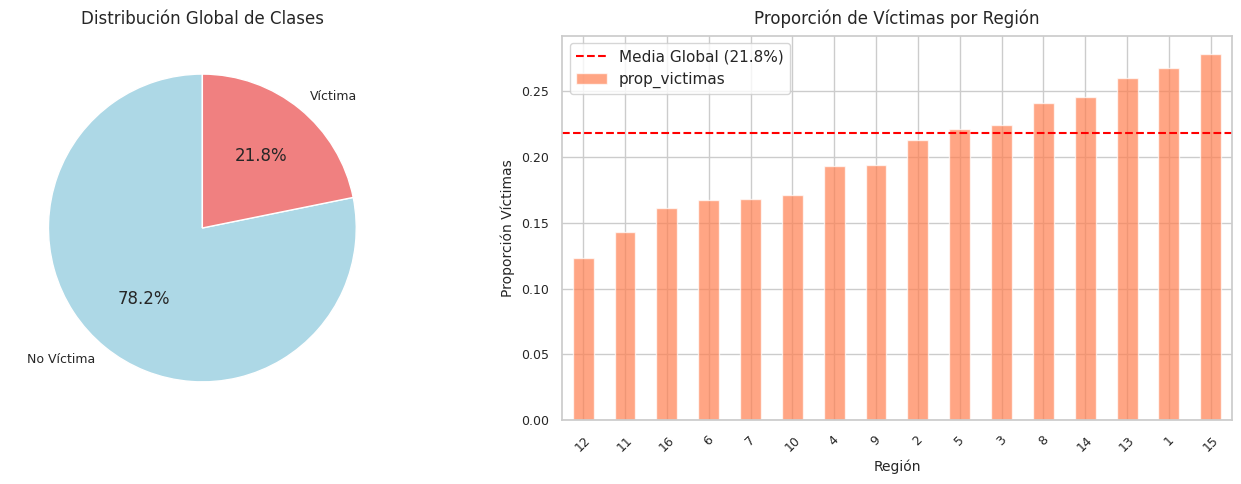


Configuración de balanceo lista
Variables creadas:
config_balanceo: diccionario con todos los parámetros
scale_pos_weight: 3.58
class_weight_dict: {0: 1.0, 1: 3.5830937320299023}
smote: No necesario


In [ ]:
# ===========================================
# ANÁLISIS Y ESTRATEGIA DE BALANCEO DE CLASES
# ===========================================

# 1. ANÁLISIS GLOBAL DEL DESBALANCE
counter          = Counter(y_train_strat)
total_train      = len(y_train_strat)
prop_victimas    = counter[1] / total_train
prop_no_victimas = counter[0] / total_train
ratio_desbalance = counter[0] / counter[1]

print(f"\nDistribución de clases en entrenamiento:")
print(f"Total observaciones: {total_train:,}")
print(f"No víctimas (0): {counter[0]:,} ({prop_no_victimas:.1%})")
print(f"Víctimas (1): {counter[1]:,} ({prop_victimas:.1%})")
print(f"Ratio desbalance: {ratio_desbalance:.2f}:1")

# 2. ANÁLISIS POR REGIÓN
print(f"\nDesbalance por región:")
df_regional = pd.DataFrame({
    'region': reg_train,
    'victimizacion': y_train_strat
})

regional_analysis = df_regional.groupby('region')['victimizacion'].agg([
    'count', 'sum', 'mean'
]).round(3)
regional_analysis.columns = ['total_obs', 'num_victimas', 'prop_victimas']
regional_analysis['ratio'] = (regional_analysis['total_obs'] - regional_analysis['num_victimas']) / regional_analysis['num_victimas']
regional_analysis = regional_analysis.sort_values('prop_victimas')

print(regional_analysis)

# 3. IDENTIFICAR TIPO DE DESBALANCE
print(f"\nEstrategia recomendada:")
if ratio_desbalance < 2:
    estrategia_tipo = "leve"
    print(f"Desbalance LEVE (ratio < 2:1)")
    print(f"Usar class_weight='balanced' solamente")
elif ratio_desbalance < 4:
    estrategia_tipo = "moderado"
    print(f"Desbalance MODERADO (2:1 - 4:1)")
    print(f"Combinar class_weight + scale_pos_weight")
else:
    estrategia_tipo = "severo"
    print(f"Desbalance SEVERO (ratio > 4:1)")
    print(f"Usar SMOTE + class_weight")

# 4. CONFIGURAR PARÁMETROS DE BALANCEO
print(f"\nConfiguración de parámetros:")

# Para XGBoost
scale_pos_weight = ratio_desbalance
print(f"XGBoost scale_pos_weight: {scale_pos_weight:.2f}")

# Para modelos con class_weight
class_weight_dict = {0: 1.0, 1: ratio_desbalance}
print(f"Class weight dict: {class_weight_dict}")

# Para SMOTE (si es necesario)
if estrategia_tipo == "severo":
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    print(f"SMOTE configurado para oversampling")
else:
    smote = None
    print(f"SMOTE no necesario para este nivel de desbalance")

# 5. VISUALIZACIÓN DEL DESBALANCE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Distribución global
colors = ['lightblue', 'lightcoral']
axes[0].pie([prop_no_victimas, prop_victimas],
           labels=['No Víctima', 'Víctima'],
           autopct='%1.1f%%',
           colors=colors,
           startangle=90)
axes[0].set_title('Distribución Global de Clases')

# Gráfico 2: Variación por región
regional_analysis['prop_victimas'].plot(kind='bar', ax=axes[1], color='coral', alpha=0.7)
axes[1].axhline(y=prop_victimas, color='red', linestyle='--',
                label=f'Media Global ({prop_victimas:.1%})')
axes[1].set_title('Proporción de Víctimas por Región')
axes[1].set_ylabel('Proporción Víctimas')
axes[1].set_xlabel('Región')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 6. GUARDAR CONFIGURACIÓN PARA MODELOS
config_balanceo = {
    'ratio_desbalance'  : ratio_desbalance,
    'prop_victimas'     : prop_victimas,
    'estrategia_tipo'   : estrategia_tipo,
    'scale_pos_weight'  : scale_pos_weight,
    'class_weight_dict' : class_weight_dict,
    'smote_obj'         : smote,
    'regional_analysis' : regional_analysis
}

print(f"\nConfiguración de balanceo lista")
print(f"Variables creadas:")
print(f"config_balanceo: diccionario con todos los parámetros")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")
print(f"class_weight_dict: {class_weight_dict}")
print(f"smote: {'Configurado' if smote is not None else 'No necesario'}")


### **Definición de métricas de performance para clasificación desbalanceada**

* La selección de **F1-score como métrica primaria** responde a la naturaleza desequilibrada del problema (proporción 3.58:1) donde la precisión tradicional sería engañosa. F1-score proporciona **equilibrio armónico entre precisión y recuperación**, optimizando simultáneamente la capacidad de detectar víctimas reales (recuperación) y eficiencia en asignación de recursos (precisión), evitando compensaciones extremas hacia una sola dimensión.

* La **asignación de costos diferenciados** (FN=3, FP=1) refleja que el costo social de no detectar víctimas reales supera significativamente el costo de intervenciones innecesarias. Esta estructura sensible al costo informa tanto la optimización de hiperparámetros como la selección de umbral óptimo, priorizando alta sensibilidad para detectar casos de riesgo real mientras mantiene la precisión razonable para la viabilidad operacional.

* El **conjunto de métricas secundarias** (AUC-ROC, Balanced Accuracy, Sensibilidad, Especificidad) proporciona una evaluación multidimensional que captura diferentes aspectos del rendimiento. AUC-ROC evalúa la capacidad discriminativa independiente del umbral, mienhtas Balanced Accuracy corrige la precisión por desequilibrio. Esta aproximación integral previene la optimización sesgada hacia métricas únicas que pueden enmascarar debilidades específicas.

* La **función de evaluación integrada** calcula métricas interpretables para tomadores de decisión: tasa de detección (% víctimas identificadas), eficiencia de recursos (% precisión en intervenciones), y costo total operacional. El puntaje personalizado para grid search optimiza directamente las compensaciones relevantes para la política, asegurando que la selección de modelos refleje los objetivos aplicados más que optimización estádistica.

In [ ]:
# ===========================================
# DEFINICIÓN DE MÉTRICAS DE PERFORMANCE
# ===========================================

# 1. CONTEXTO DEL PROBLEMA
print("\nContexto del problema:")
print("Clasificación binaria de victimización personal con desbalance moderado (3.58:1)")
print("Objetivo: Identificar territorios/personas con mayor riesgo para políticas públicas")

# 2. COSTOS DE ERROR
costo_fn = 3  # No detectar víctima real
costo_fp = 1  # Falsa alarma
costo_tp = 0  # Detección correcta
costo_tn = 0  # No detección correcta

print("\nCostos asignados:")
print(f"Falso Negativo (FN): {costo_fn} - No detectar víctima real")
print(f"Falso Positivo (FP): {costo_fp} - Falsa alarma")
print("Prioridad: Alta sensibilidad para detectar víctimas reales")

# 3. MÉTRICAS SELECCIONADAS
print("\nMétricas de evaluación:")
print("Métrica primaria: F1 Score (equilibra precision y recall)")
print("Métricas secundarias: AUC-ROC, Balanced Accuracy, Sensibilidad, Especificidad, Precisión")

# 4. FUNCIÓN EVALUACIÓN
def calcular_metricas_completas(y_true, y_pred, y_proba=None):
    """Calcula métricas completas para el problema de victimización"""
    from sklearn.metrics import (
        f1_score, roc_auc_score, balanced_accuracy_score,
        precision_score, recall_score, confusion_matrix
    )

    f1            = f1_score(y_true, y_pred)
    precision     = precision_score(y_true, y_pred)
    recall        = recall_score(y_true, y_pred)
    balanced_acc  = balanced_accuracy_score(y_true, y_pred)
    auc           = roc_auc_score(y_true, y_proba) if y_proba is not None else None

    tn, fp, fn, tp  = confusion_matrix(y_true, y_pred).ravel()
    especificidad   = tn / (tn + fp) if (tn + fp) > 0 else 0

    costo_total         = (fn * costo_fn) + (fp * costo_fp)
    tasa_deteccion      = tp / (tp + fn) if (tp + fn) > 0 else 0
    eficiencia_recursos = tp / (tp + fp) if (tp + fp) > 0 else 0

    return {
        'f1_score'          : f1,
        'auc_roc'           : auc,
        'balanced_accuracy' : balanced_acc,
        'sensibilidad'      : recall,
        'especificidad'     : especificidad,
        'precision'         : precision,
        'costo_total'       : costo_total,
        'tasa_deteccion'    : tasa_deteccion,
        'eficiencia_recursos': eficiencia_recursos,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

# 5. SCORE PERSONALIZADO
def costo_personalizado(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp    = confusion_matrix(y_true, y_pred).ravel()
    costo             = (fn * costo_fn) + (fp * costo_fp)
    max_costo_posible = len(y_true) * max(costo_fn, costo_fp)
    score             = 1 - (costo / max_costo_posible)
    return score

scorer_costo_personalizado = make_scorer(costo_personalizado, greater_is_better=True)

# 6. CONFIGURACIÓN FINAL
metrica_principal = 'f1'
scorer_principal = 'f1'

print(f"\nConfiguración de Grid Search:")
print(f"Métrica de optimización: {metrica_principal}")
print("Validación cruzada: StratifiedKFold(n_splits=5)")

# 7. CONFIGURACIÓN COMPLETA
config_metricas = {
    'metrica_principal'     : metrica_principal,
    'scorer_principal'      : scorer_principal,
    'scorer_personalizado'  : scorer_costo_personalizado,
    'costos': {'fn'         : costo_fn, 'fp': costo_fp, 'tp': costo_tp, 'tn': costo_tn},
    'funcion_evaluacion'    : calcular_metricas_completas,
}


Contexto del problema:
Clasificación binaria de victimización personal con desbalance moderado (3.58:1)
Objetivo: Identificar territorios/personas con mayor riesgo para políticas públicas

Costos asignados:
Falso Negativo (FN): 3 - No detectar víctima real
Falso Positivo (FP): 1 - Falsa alarma
Prioridad: Alta sensibilidad para detectar víctimas reales

Métricas de evaluación:
Métrica primaria: F1 Score (equilibra precision y recall)
Métricas secundarias: AUC-ROC, Balanced Accuracy, Sensibilidad, Especificidad, Precisión

Configuración de Grid Search:
Métrica de optimización: f1
Validación cruzada: StratifiedKFold(n_splits=5)


### **Grid Search Multi-Algoritmo: Optimización de Hiperparámetros**

* La evaluación compara **tres familias algorítmicas con sesgos inductivos diferentes**: SVM lineal para capturar relaciones lineales con regularización robusta, Random Forest para interacciones no lineales mediante ensemble bagging, y XGBoost para gradient boosting optimizado con control avanzado de overfitting. Esta diversidad algorítmica explora diferentes aproximaciones al problema de clasificación desequilibrada, maximizando la probabilidad de identificar la mejor estrategia para los datos específicos.

* Los **parametros grids se diseñan enfocados en lugar de exhaustivos**, priorizando hiperparámetros críticos para rendimiento en datos desequilibrados. SVM explora regularización (C) y estrategias de equilibrio, Random Forest optimiza la complejidad de árbol manteniendo fijos parámetros de eficiencia, y XGBoost examina boosting rounds, tree Depth y scale_pos_weight alrededor del ratio empírico. Esta aproximación equilibra la exploración integral con eficiencia computacional.

* La **validación cruzada StratifiedKFold mantiene la distribución de clases** en cada pliegue, asegurando que la optimización de hiperparámetros no esté sesgada por la variabilidad muestral del desbalanceo. La métrica F1 como función de puntuación optimiza directamente el equilibrio de precisión-recuperación relevante para el problema, mientras que la paralelización aprovecha recursos computacionales disponibles para la aceleración del proceso.

* El **marco de comparación integra rendimiento, eficiencia y complejidad**: mejor puntaje CV indica capacidad predictiva, tiempo de entrenamiento refleja el costo computacional, y número de combinaciones evaluadas cuantifican la minuciosidad de la búsqueda. Esta evaluación multidimensional informa la selección final considerando las compensaciones entre el poder predictivo, los requisitos computacionales y la robustez de la optimización a través de diferentes enfoques algorítmicos.

In [ ]:
# =============================================================
#  GRID SEARCH  –  SVM  vs  Random Forest  vs  XGBoost
#  (SVM lineal con pesos, RF robusto y XGB balanceado)
# =============================================================

# 0. COLUMNAS A EXCLUIR
cols_excluir   = ["strata", "enc_region"]
X_train_clean  = X_train_strat.drop(cols_excluir, axis=1, errors="ignore")

# 1. CONFIGURACIÓN GENERAL
cv_strategy          = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrica_optimizacion = config_metricas["metrica_principal"]

print(f"Métrica de optimización : {metrica_optimizacion}")
print("Validación cruzada      : 5-fold estratificada")
print(f"Observaciones en train  : {X_train_clean.shape[0]:,}")
print(f"Variables (post-drop)   : {X_train_clean.shape[1]}\n")


# 2. SVM LINEAL
svm_base = make_pipeline(
    StandardScaler(with_mean=False),
    LinearSVC(dual=False, random_state=42)
)
param_grid_svm = {
    "linearsvc__C"           : [0.1, 1, 10],
    "linearsvc__class_weight": [None, {0:1, 1:5}, {0:1, 1:10}]
}
print(f"SVM-LINEAL - Combinaciones: {len(param_grid_svm['linearsvc__C'])*len(param_grid_svm['linearsvc__class_weight'])}")


# 3. RANDOM FOREST
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid_rf = {
    "n_estimators"     : [120],
    "max_depth"        : [10, 15],
    "min_samples_leaf" : [3],
    "max_features"     : [0.6],
    "class_weight"     : [{0:1, 1:10}]
}
print(f"Random Forest - Combinaciones: {2}")  # 2 valores de max_depth

# 4. XGBOOST BALANCEADO
ratio = (y_train_strat==0).sum() / (y_train_strat==1).sum()   # ajuste desequilibrio

xgb_base = XGBClassifier(
    objective        ="binary:logistic",
    eval_metric      ="aucpr",
    n_jobs           =max(1, os.cpu_count()//2),
    random_state     =42,
    verbosity        =0,
    tree_method      ="hist",          # rápido en CPU
)
param_grid_xgb = {
    "n_estimators"     : [200, 400],
    "max_depth"        : [4, 6],
    "learning_rate"    : [0.05],
    "subsample"        : [0.8],
    "colsample_bytree" : [0.8],
    "scale_pos_weight" : [ratio-1, ratio, ratio+1]
}
print(f"XGBoost - Combinaciones: {len(param_grid_xgb['n_estimators'])*len(param_grid_xgb['max_depth'])*len(param_grid_xgb['scale_pos_weight'])}")

# 5. EJECUTAR GRID SEARCH
modelos = {
    "SVM"          : (svm_base, param_grid_svm),
    "Random Forest": (rf_base,  param_grid_rf),
    "XGBoost"      : (xgb_base, param_grid_xgb)
}

resultados_cv, mejores_modelos = {}, {}
print("\n" + "="*50)
print("EJECUTANDO GRID SEARCH")
print("="*50)

for nombre, (modelo, grid) in modelos.items():
    print(f"\n{nombre.upper()}\n" + "-"*30)
    tic = time.time()
    gs = GridSearchCV(
        modelo, grid,
        cv=cv_strategy, scoring=metrica_optimizacion,
        n_jobs=max(1, os.cpu_count()//2),
        verbose=0, pre_dispatch="2*n_jobs",
        return_train_score=False
    )
    gs.fit(X_train_clean, y_train_strat)
    dur = time.time() - tic

    resultados_cv[nombre] = {
        "CV_Score"   : gs.best_score_,
        "Tiempo_s"   : dur,
        "best_params": gs.best_params_
    }
    mejores_modelos[nombre] = gs.best_estimator_

    print(f"Mejor {metrica_optimizacion}: {gs.best_score_:.4f}")
    print(f"Parámetros           : {gs.best_params_}")
    print(f"Tiempo total         : {dur:.1f} s")

# 6. TABLA COMPARATIVA FORMAL
resumen = (
    pd.DataFrame(resultados_cv)
      .T[["CV_Score", "Tiempo_s"]]
      .rename(columns={"CV_Score": "Mejor Score CV",
                       "Tiempo_s": "Tiempo (s)"})
      .round({"Mejor Score CV": 4, "Tiempo (s)": 1})
)

# añadir nº de combinaciones para cada grid
resumen["Grid Comb."] = [
    len(param_grid_svm["linearsvc__C"])     * len(param_grid_svm["linearsvc__class_weight"]),
    len(param_grid_rf["max_depth"]),        # 2
    len(param_grid_xgb["n_estimators"]) *
    len(param_grid_xgb["max_depth"]) *
    len(param_grid_xgb["scale_pos_weight"])
]
resumen = resumen[["Mejor Score CV", "Tiempo (s)", "Grid Comb."]]

# ordenar por score descendente
resumen = resumen.sort_values("Mejor Score CV", ascending=False)

print("\n" + "="*50)
print("RESUMEN COMPARATIVO")
print("="*50)
print(resumen.to_string())

Métrica de optimización : f1
Validación cruzada      : 5-fold estratificada
Observaciones en train  : 39,850
Variables (post-drop)   : 26

SVM-LINEAL - Combinaciones: 9
Random Forest - Combinaciones: 2
XGBoost - Combinaciones: 12

EJECUTANDO GRID SEARCH

SVM
------------------------------
Mejor f1: 0.4378
Parámetros           : {'linearsvc__C': 10, 'linearsvc__class_weight': {0: 1, 1: 5}}
Tiempo total         : 84.1 s

RANDOM FOREST
------------------------------
Mejor f1: 0.4253
Parámetros           : {'class_weight': {0: 1, 1: 10}, 'max_depth': 15, 'max_features': 0.6, 'min_samples_leaf': 3, 'n_estimators': 120}
Tiempo total         : 151.8 s

XGBOOST
------------------------------
Mejor f1: 0.4504
Parámetros           : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'scale_pos_weight': np.float64(3.5830937320299023), 'subsample': 0.8}
Tiempo total         : 651.2 s

RESUMEN COMPARATIVO
              Mejor Score CV  Tiempo (s)  Grid Comb.
XGBoos

## 5. Evaluación <a name="seccion5"></a>
Incluir en esta sección:
- Métricas de performance de los mejores modelos encontrados a partir del grid search
- Tiempos de cómputo
- Matriz de confusión (si aplica)

### **Evaluación en conjunto de test: Validación de generalización**

* La evaluación en **test set no contaminado** proporciona estimación unbiased del performance real de cada modelo en datos never-seen, simulando aplicación operacional. La limpieza de variables auxiliares (strata, enc_region) asegura que la evaluación se base exclusivamente en features disponibles para predicción, mientras la verificación de proporciones confirma que el test set mantiene representatividad de la distribución nacional.

* El **procesamiento diferenciado por algoritmo** extrae tanto predicciones binarias como probabilidades/scores continuos, reconociendo que diferentes modelos proporcionan uncertainty estimates mediante mecanismos distintos. SVM genera decision functions transformadas via sigmoid, Random Forest y XGBoost producen probabilidades directas. Esta dualidad permite evaluación tanto de classification performance como de calibration quality para different threshold scenarios.

* La **función de evaluación integrada** calcula suite completa de métricas relevantes para clasificación desbalanceada: F1-score para balance precision-recall, AUC-ROC para capacidad discriminativa threshold-independent, sensibilidad/especificidad para trade-offs detection, y costo total para policy relevance. Las matrices de confusión proporcionan insights granulares sobre tipos específicos de errores y sus implicaciones operacionales.


In [ ]:
# ===============================
# EVALUACIÓN EN CONJUNTO DE TEST
# ===============================

# LIMPIEZA DE COLUMNAS
X_test_clean = X_test_strat.drop(["strata", "enc_region"], axis=1, errors="ignore")

print(f"Evaluando en conjunto de test: {len(X_test_clean):,} observaciones")
print(f"Proporción víctimas en test: {y_test_strat.mean():.3f}")

# 1. PREDICCIONES
modelos_test = {
    "SVM"          : mejores_modelos["SVM"],
    "Random Forest": mejores_modelos["Random Forest"],
    "XGBoost"      : mejores_modelos["XGBoost"]
}

predicciones_test, probabilidades_test = {}, {}

for nombre, modelo in modelos_test.items():
    X_proc = X_test_clean
    predicciones_test[nombre] = modelo.predict(X_proc)

    if hasattr(modelo, "predict_proba"):
        probabilidades_test[nombre] = modelo.predict_proba(X_proc)[:, 1]
    elif hasattr(modelo, "decision_function"):
        dec = modelo.decision_function(X_proc)
        dec = np.clip(dec, -500, 500)
        probabilidades_test[nombre] = 1 / (1 + np.exp(-dec))
    else:
        probabilidades_test[nombre] = np.full(len(X_proc), np.nan)

# 2. FUNCIÓN DE MÉTRICAS
def metricas_completas(y_true, y_pred, y_proba, costos):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "F1 Score"         : f1_score(y_true, y_pred),
        "AUC-ROC"          : roc_auc_score(y_true, y_proba) \
                             if not np.isnan(y_proba).all() else np.nan,
        "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred),
        "Sensibilidad"     : recall_score(y_true, y_pred),
        "Especificidad"    : recall_score(y_true, y_pred, pos_label=0),
        "Precisión"        : precision_score(y_true, y_pred),
        "Costo Total"      : fp*costos.get("fp",0) + fn*costos.get("fn",0) \
                             if isinstance(costos, dict) else np.nan,
        "Matriz"           : (tn, fp, fn, tp)
    }

costos = config_metricas.get("costos", {})
resultados_test = {
    n: metricas_completas(
        y_test_strat, predicciones_test[n],
        probabilidades_test[n], costos
    ) for n in modelos_test
}

# 3. TABLA COMPARATIVA
print(f"\n{'='*70}")
print("EVALUACIÓN COMPARATIVA EN CONJUNTO DE TEST")
print(f"{'='*70}\n")

df_cmp = pd.DataFrame(resultados_test).T

print(f"{'Métrica':<25} {'SVM':<15} {'Random Forest':<15} {'XGBoost':<15}")
print(f"{'-'*25} {'-'*15} {'-'*15} {'-'*15}")

for met in ["F1 Score","AUC-ROC","Balanced Accuracy",
            "Sensibilidad","Especificidad","Precisión"]:
    s, r, x = df_cmp.loc["SVM", met], df_cmp.loc["Random Forest", met], df_cmp.loc["XGBoost", met]
    print(f"{met:<25} {s:<15.3f} {r:<15.3f} {x:<15.3f}")

# Costo
if "Costo Total" in df_cmp:
    print(f"{'-'*25} {'-'*15} {'-'*15} {'-'*15}")
    cs, cr, cx = df_cmp.loc["SVM","Costo Total"], df_cmp.loc["Random Forest","Costo Total"], df_cmp.loc["XGBoost","Costo Total"]
    print(f"{'Costo Total':<25} {cs:<15.0f} {cr:<15.0f} {cx:<15.0f}")

print(f"{'='*70}")

# 4. MATRICES DE CONFUSIÓN
print("\nMATRICES DE CONFUSIÓN (TN | FP | FN | TP)")
for n in modelos_test:
    tn, fp, fn, tp = resultados_test[n]["Matriz"]
    print(f"{n:<13}: {tn:5d} | {fp:5d} | {fn:5d} | {tp:5d}")

Evaluando en conjunto de test: 9,963 observaciones
Proporción víctimas en test: 0.218

EVALUACIÓN COMPARATIVA EN CONJUNTO DE TEST

Métrica                   SVM             Random Forest   XGBoost        
------------------------- --------------- --------------- ---------------
F1 Score                  0.430           0.422           0.445          
AUC-ROC                   0.703           0.676           0.712          
Balanced Accuracy         0.633           0.624           0.648          
Sensibilidad              0.792           0.717           0.666          
Especificidad             0.474           0.532           0.629          
Precisión                 0.295           0.299           0.334          
------------------------- --------------- --------------- ---------------
Costo Total               5457            5491            5066           

MATRICES DE CONFUSIÓN (TN | FP | FN | TP)
SVM          :  3690 |  4101 |   452 |  1720
Random Forest:  4145 |  3646 |   615 |  1

### **Métrica territorial: Evaluación de robustez regional**

Esta función evalúa modelos considerando **performance territorial**, no solo promedio global. Reconoce que un modelo para política nacional debe funcionar bien en todas las regiones.



In [ ]:
# ===================================
# EVALUAR CON MÉTRICA TERRITORIAL
# ===================================
def metrica_heterogeneidad_territorial(y_true, y_pred, regiones):

    # 1. Performance ponderado por población
    f1_regionales = {}
    pesos = {}

    for region in regiones.unique():
        mask = regiones == region
        if mask.sum() >= 20:  # Mínimo para F1 estable
            f1_regionales[region] = f1_score(y_true[mask], y_pred[mask])
            pesos[region] = mask.sum() / len(regiones)

    # 2. F1 promedio ponderado
    f1_ponderado = sum(f1 * pesos[region] for region, f1 in f1_regionales.items())

    # 3. Coeficiente de variación territorial
    f1_values = list(f1_regionales.values())
    cv_territorial = np.std(f1_values) / np.mean(f1_values)

    # 4. Performance mínimo (worst-case scenario)
    f1_minimo = min(f1_values)

    # 5. Score final: combina performance, estabilidad y worst-case
    # Penaliza modelos que fallen catastrophically en alguna región
    penalizacion_cv = 0.3
    penalizacion_minimo = 0.2

    score_final = (
        f1_ponderado * (1 - penalizacion_cv * cv_territorial) *
        (1 - penalizacion_minimo * max(0, (0.3 - f1_minimo) / 0.3))
    )

    return {
        'score_territorial': score_final,
        'f1_ponderado': f1_ponderado,
        'cv_territorial': cv_territorial,
        'f1_minimo': f1_minimo,
        'f1_maximo': max(f1_values),
        'regiones_efectivas': sum(1 for f1 in f1_values if f1 >= 0.25)
    }

  # EVALUAR SUS TRES MODELOS CON MÉTRICA TERRITORIAL
modelos_eval = {
    'XGBoost': mejores_modelos['XGBoost'],
    'RandomForest': mejores_modelos['Random Forest'],
    'SVM': mejores_modelos['SVM']
}

print("COMPARACIÓN TERRITORIAL DE MODELOS:")
print("="*50)

resultados_territoriales = {}

for nombre, modelo in modelos_eval.items():
    # Predicciones
    if hasattr(modelo, 'predict'):
        y_pred = modelo.predict(X_test_clean)
    else:
        if hasattr(modelo, 'decision_function'):
             y_pred = (modelo.decision_function(X_test_clean) > 0).astype(int)
        else:
             print(f"Warning: Model {nombre} has no 'predict' or 'decision_function' method.")
             y_pred = np.zeros(len(X_test_clean)) # Default to all 0s

    # Métrica territorial
    resultado = metrica_heterogeneidad_territorial(y_test_strat, y_pred, reg_test)
    resultados_territoriales[nombre] = resultado

    print(f"\n{nombre}:")
    print(f"  Score Territorial: {resultado['score_territorial']:.3f}")
    print(f"  F1 Promedio Ponderado: {resultado['f1_ponderado']:.3f}")
    print(f"  Variabilidad Territorial (CV): {resultado['cv_territorial']:.3f}")
    print(f"  F1 Mínimo (peor región): {resultado['f1_minimo']:.3f}")
    print(f"  F1 Máximo (mejor región): {resultado['f1_maximo']:.3f}")
    print(f"  Regiones Efectivas (F1≥0.25): {resultado['regiones_efectivas']}")

# Tabla comparativa final
print(f"\n{'Modelo':<15} {'Score Terr.':<12} {'F1 Prom.':<10} {'CV Terr.':<10} {'F1 Min.':<8}")
print("-" * 55)
for nombre, res in resultados_territoriales.items():
    print(f"{nombre:<15} {res['score_territorial']:<12.3f} {res['f1_ponderado']:<10.3f} {res['cv_territorial']:<10.3f} {res['f1_minimo']:<8.3f}")

COMPARACIÓN TERRITORIAL DE MODELOS:

XGBoost:
  Score Territorial: 0.412
  F1 Promedio Ponderado: 0.434
  Variabilidad Territorial (CV): 0.160
  F1 Mínimo (peor región): 0.294
  F1 Máximo (mejor región): 0.508
  Regiones Efectivas (F1≥0.25): 16

RandomForest:
  Score Territorial: 0.383
  F1 Promedio Ponderado: 0.414
  Variabilidad Territorial (CV): 0.144
  F1 Mínimo (peor región): 0.248
  F1 Máximo (mejor región): 0.498
  Regiones Efectivas (F1≥0.25): 15

SVM:
  Score Territorial: 0.406
  F1 Promedio Ponderado: 0.424
  Variabilidad Territorial (CV): 0.139
  F1 Mínimo (peor región): 0.301
  F1 Máximo (mejor región): 0.517
  Regiones Efectivas (F1≥0.25): 16

Modelo          Score Terr.  F1 Prom.   CV Terr.   F1 Min. 
-------------------------------------------------------
XGBoost         0.412        0.434      0.160      0.294   
RandomForest    0.383        0.414      0.144      0.248   
SVM             0.406        0.424      0.139      0.301   


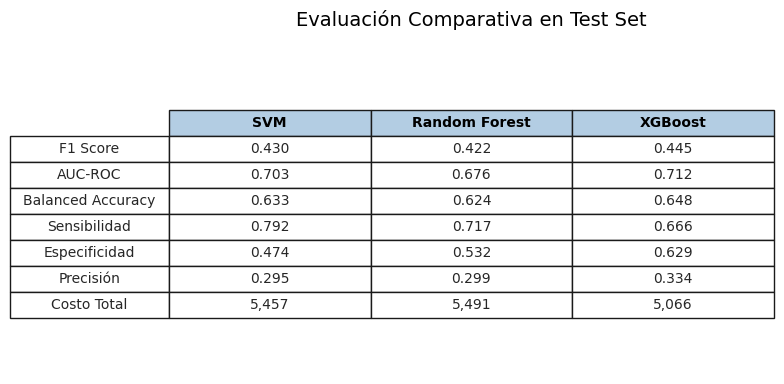

In [ ]:
# ===================================
# Evaluación Comparativa en Test Set
# ===================================

# Tema
sage  = "#B3CDE3"      # Random Forest
mid   = "#92A8D1"    # SVM
coral = "lightcoral" # XGBoost
black = "#000000"
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.titlesize" : 14,
    "axes.labelsize" : 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# Extraer sólo las métricas que quieres mostrar
filas        = ["F1 Score","AUC-ROC","Balanced Accuracy","Sensibilidad","Especificidad","Precisión","Costo Total"]
col_modelos  = ["SVM","Random Forest","XGBoost"]

# Construir la matriz de texto
table_data = []
for met in filas:
    row = [ f"{df_cmp.loc[model, met]:.3f}" if met!="Costo Total"
            else f"{int(df_cmp.loc[model, met]):,}"
            for model in col_modelos ]
    table_data.append(row)

#  Dibujar la tabla
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')

tbl = ax.table(
    cellText=table_data,
    rowLabels=filas,
    colLabels=col_modelos,
    cellLoc='center',
    rowLoc='center',
    loc='center'
)

# Dar formato
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Cabecera con fondo azul claro y texto blanco
# Style header cells (row 0) starting from column 0
header_color = "#B3CDE3" # Light blue color
for (row, col), cell in tbl.get_celld().items():
    if row == 0:  # Style all cells in row 0
        cell.set_facecolor(header_color)
        cell.set_text_props(weight='bold', color='black') # Changed text color to black for better contrast

# Título
ax.set_title("Evaluación Comparativa en Test Set", pad=20, color=black)

plt.tight_layout()
plt.show()

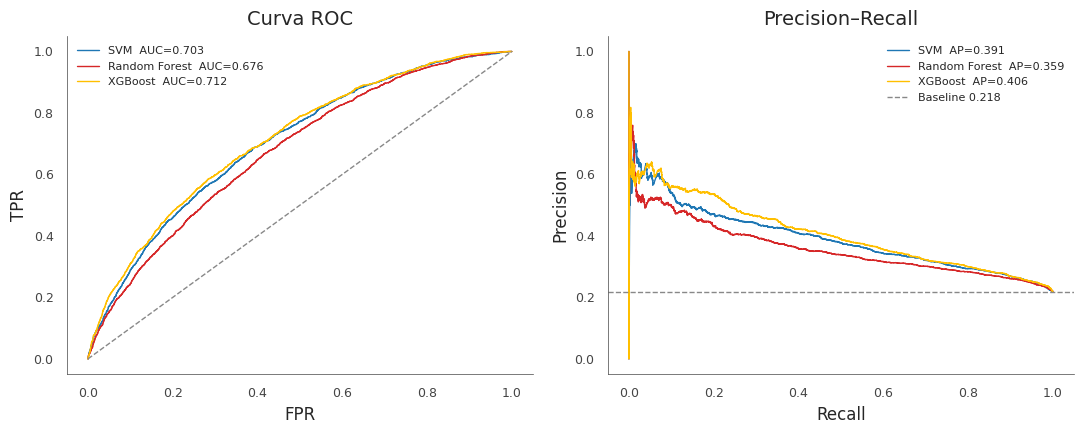

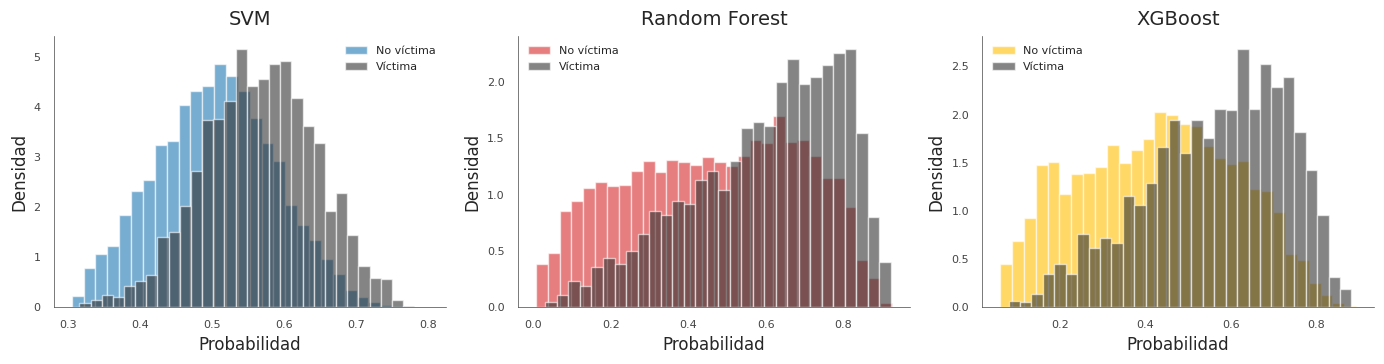

In [ ]:
# ===========================================
# GRÁFICOS DE PERFORMANCE – SVM  RF  XGBoost
# ===========================================

import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.metrics import (roc_curve, precision_recall_curve, auc,
                             average_precision_score, confusion_matrix,
                             f1_score, roc_auc_score, balanced_accuracy_score,
                             recall_score, precision_score)

sns.set_style("white")
colors = {"SVM": "#1f77b4", "Random Forest": "#d62728", "XGBoost": "#ffbf00"}

SPINE_COL = "#444444"   # gris oscuro
SPINE_LW  = 0.5         # grosor fino

# Probabilidades
mejor_svm = mejores_modelos["SVM"]
mejor_rf  = mejores_modelos["Random Forest"]
mejor_xgb = mejores_modelos["XGBoost"]

y_proba_svm = 1/(1+np.exp(-mejor_svm.decision_function(X_test_clean)))
y_proba_rf  = mejor_rf.predict_proba(X_test_clean)[:,1]
y_proba_xgb = mejor_xgb.predict_proba(X_test_clean)[:,1]
y_probas = {"SVM": y_proba_svm, "Random Forest": y_proba_rf, "XGBoost": y_proba_xgb}

# CURVAS ROC / PR
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
for ax in axes:
    for side in ("bottom", "left"):
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color(SPINE_COL)
        ax.spines[side].set_linewidth(SPINE_LW)
    for side in ("top", "right"):
        ax.spines[side].set_visible(False)
    ax.tick_params(axis="both", colors=SPINE_COL, width=SPINE_LW, labelsize=9)
    ax.grid(False)

for name, proba in y_probas.items():
    fpr, tpr, _  = roc_curve(y_test_strat, proba)
    prec, rec, _ = precision_recall_curve(y_test_strat, proba)
    axes[0].plot(fpr, tpr, lw=1, color=colors[name],
                 label=f"{name}  AUC={auc(fpr, tpr):.3f}")
    axes[1].plot(rec, prec, lw=1, color=colors[name],
                 label=f"{name}  AP={average_precision_score(y_test_strat, proba):.3f}")

axes[0].plot([0, 1], [0, 1], ls="--", color="#888888", lw=1)
axes[1].axhline(y_test_strat.mean(), ls="--", color="#888888", lw=1,
                label=f"Baseline {y_test_strat.mean():.3f}")
axes[0].set(title="Curva ROC", xlabel="FPR", ylabel="TPR");  axes[0].legend(frameon=False, fontsize=8)
axes[1].set(title="Precision–Recall", xlabel="Recall", ylabel="Precision"); axes[1].legend(frameon=False, fontsize=8)
plt.tight_layout()

# DISTRIBUCIONES
fig2, axs = plt.subplots(1, 3, figsize=(14, 3.8))
for ax, (name, proba) in zip(axs, y_probas.items()):
    ax.hist(proba[y_test_strat == 0], bins=30, alpha=.6, color=colors[name],
            density=True, label="No víctima", lw=1, edgecolor='white')
    ax.hist(proba[y_test_strat == 1], bins=30, alpha=.6, color="#333333",
            density=True, label="Víctima", lw=1, edgecolor='white')
    ax.set(title=name, xlabel="Probabilidad", ylabel="Densidad")
    for side in ("bottom", "left"):
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color(SPINE_COL)
        ax.spines[side].set_linewidth(SPINE_LW)
    for side in ("top", "right"):
        ax.spines[side].set_visible(False)
    ax.tick_params(axis="both", colors=SPINE_COL, width=SPINE_LW, labelsize=8)
    ax.grid(False); ax.legend(frameon=False, fontsize=8)
plt.tight_layout()

## 6. Explicabilidad e interpretabilidad <a name="seccion6"></a>
Incluir en esta sección:
- Importancia de los atributos
- Aplicación de métodos como SHAP values o LIME

In [ ]:
# DICCIONARIO DE ETIQUETAS
etiquetas_variables = {
    'vp_dc': 'Victimización',
    'index_desorden': 'Index desorden barrio',
    'index_incivil': 'Index incivilidades',
    'index_acciones_vecinos': 'Index acciones vecinales',
    'index_discapacidad': 'Index discapacidad',
    'rph_nivel_1': 'Educ. (Básica)',
    'rph_nivel_2': 'Educ. (Secundaria)',
    'rph_nivel_3': 'Educ. (Superior)',
    'rph_nse_2': 'NSE Medio',
    'rph_nse_3': 'NSE Alto',
    'presencia_carabineros_2': 'Pressencia CCH: Igual',
    'presencia_carabineros_3': 'Pressencia CCH: Menos',
    'presencia_trafico_2': 'Tráfico: Casi nunca',
    'presencia_trafico_3': 'Tráfico: Ocasional',
    'presencia_trafico_4': 'Tráfico: Frecuente',
    'presencia_trafico_5': 'Tráfico: Siempre',
    'presencia_armas_2': 'Armas: Casi nunca',
    'presencia_armas_3': 'Armas: Ocasional',
    'presencia_armas_4': 'Armas: Frecuente',
    'presencia_armas_5': 'Armas: Siempre',
    'ev_confia_cch_2': 'Confianza CCH: Bastante',
    'ev_confia_cch_3': 'Confianza CCH: Poca',
    'ev_confia_cch_4': 'Confianza CCH: Nada',
    'rph_sexo': 'Sexo (hombre)',
    'rph_situacion_laboral_a': 'Situación laboral (trabaja)',
    'rph_pertenencia_indigena': 'Origen indígena (Si)',
    'rph_nacionalidad': 'Nacionalidad',
    'enc_region': 'Región',
    'fact_pers_com': 'Factor comunal',
    'fact_pers_reg': 'Factor regional'
}

def obtener_etiqueta(variable):
    return etiquetas_variables.get(variable, variable)

def obtener_etiquetas_lista(variables):
    return [obtener_etiqueta(var) for var in variables]

def crear_df_con_etiquetas(variables, valores, nombre_valor='Valor'):
    df = pd.DataFrame({
        'Variable_Original': variables,
        'Variable': obtener_etiquetas_lista(variables),
        nombre_valor: valores
    })
    return df.sort_values(nombre_valor, ascending=False)


### **Análisis SHAP: explicabilidad e interpretabilidad**

* El **análisis de explicabilidad se aplica al modelo con mejor performance** (XGBoost) para entender qué features determinan las predicciones y cómo estos factores varían territorialmente. La preparación utiliza **sampling estratégico** del test set para balance entre comprehensiveness del análisis y eficiencia computacional, asegurando que la muestra sea representativa manteniendo tiempos de cálculo factibles para el cálculo del valor SHAP.

* La **implementación TreeExplainer** calcula contribuciones marginales de cada feature a cada predicción individual, proporcionando interpretabilidad local que puede agregarse para insights globales. Los valores SHAP cuantifican exactamente cuánto cada variable aumenta o disminuye la probabilidad de victimización para cada observación, permitiendo identificar factores protectores vs de riesgo con rigor matemático fundamentado en la teoría de juegos.

* El **análisis dual de importancia** revela tanto ranking global de features como variabilidad territorial en su relevancia predictiva. El análisis global identifica predictores universalmente importantes, mientras que el análisis regional documenta cómo diferentes características dominan en diferentes territorios, proporcionando evidencia para la adaptación de políticas según contextos locales donde ciertos factores de riesgo pueden ser más o menos relevantes.

Muestra: 1000 observaciones, 26 variables


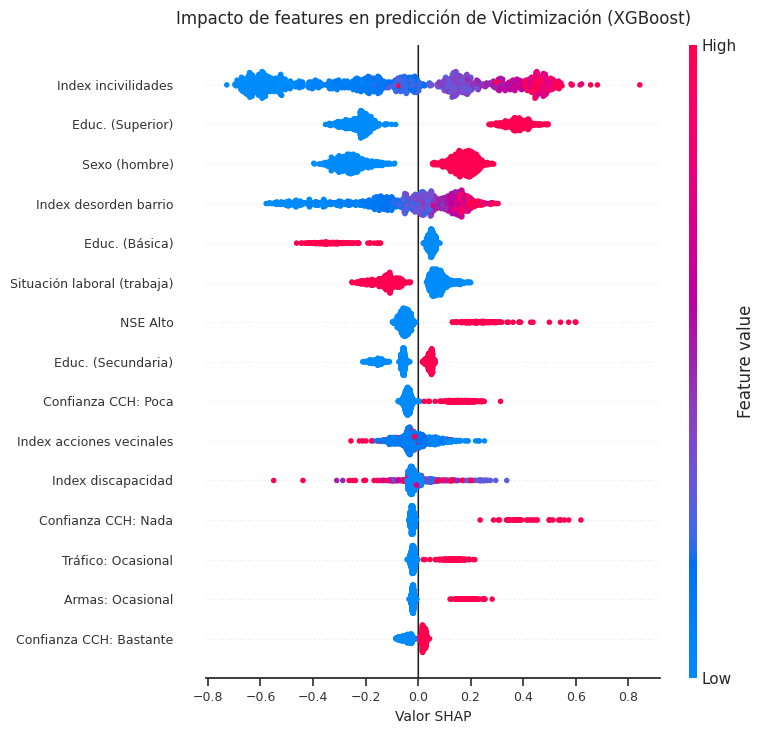

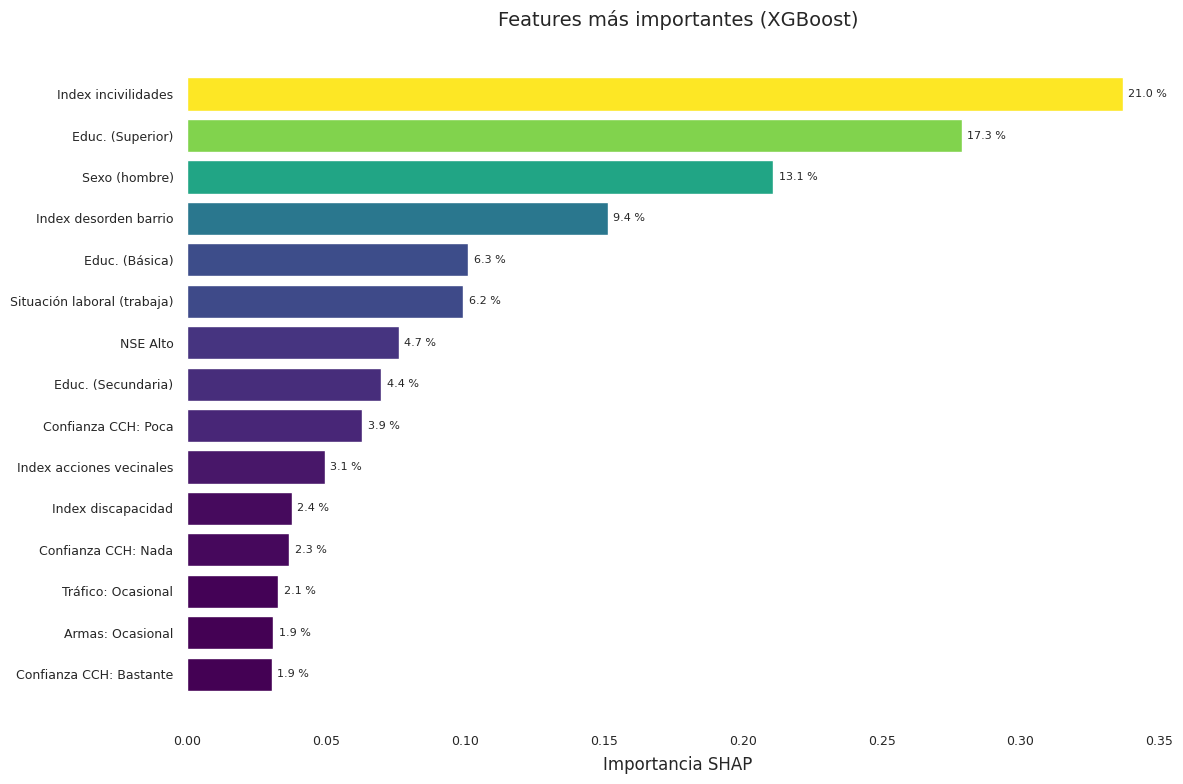

In [ ]:
# ================
# ANÁLISIS SHAP
# ================

import shap

# 1. SELECCIÓN DE MODELO
modelo_analisis = mejor_xgb
nombre_modelo   = "XGBoost"

# 2. PREPARACIÓN DE DATOS
sample_size = min(1000, len(X_test_strat))
np.random.seed(42)
idx_sample = np.random.choice(len(X_test_strat), sample_size, replace=False)

X_shap = X_test_strat.iloc[idx_sample].copy()
y_shap = y_test_strat.iloc[idx_sample].copy()

X_shap_clean  = X_shap.drop(['enc_region', 'strata'], axis=1, errors='ignore')
regiones_shap = X_shap['enc_region'] if 'enc_region' in X_shap.columns else None

print(f"Muestra: {len(X_shap_clean)} observaciones, {len(X_shap_clean.columns)} variables")

# 3. CÁLCULO SHAP
explainer = shap.TreeExplainer(modelo_analisis)
shap_values = explainer.shap_values(X_shap_clean)

if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values = shap_values[1] # SHAP values for the positive class

# 4. ANÁLISIS DE IMPORTANCIA
importancia_global = crear_df_con_etiquetas(
    X_shap_clean.columns,
    np.abs(shap_values).mean(axis=0),
    'SHAP_Importance'
)

# 5. ANÁLISIS REGIONAL
shap_regional = {}
if regiones_shap is not None:
    top_regiones = regiones_shap.value_counts().head(3)

    for region in top_regiones.index:
        mask_region = regiones_shap == region
        if mask_region.sum() >= 5:
            shap_valores_region = shap_values[mask_region]
            imp_region = crear_df_con_etiquetas(
                X_shap_clean.columns,
                np.abs(shap_valores_region).mean(axis=0),
                'SHAP_Mean'
            )
            shap_regional[region] = imp_region

# 6. VISUALIZACIONES

# GRÁFICO 1: Summary Plot
plt.figure(figsize=(12, 8))
X_shap_etiquetado = X_shap_clean.copy()
X_shap_etiquetado.columns = obtener_etiquetas_lista(X_shap_clean.columns)

shap.summary_plot(shap_values, X_shap_etiquetado, max_display=15, show=False)
plt.grid(False)
plt.axvline(x=0, color='black', linewidth=0.8, alpha=0.8)
plt.title(f'Impacto de features en predicción de Victimización ({nombre_modelo})', fontsize=12, pad=15)
plt.xlabel('Valor SHAP', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.tight_layout()
plt.show()

# GRÁFICO 2 – Ranking de Importancia
plt.figure(figsize=(12, 8))
sns.set_style("white")

top_feats  = importancia_global.head(15)
total_shap = top_feats["SHAP_Importance"].sum()

# Colores tipo SHAP (viridis degradado)
norm   = plt.Normalize(top_feats["SHAP_Importance"].min(),
                       top_feats["SHAP_Importance"].max())
colors = plt.cm.viridis(norm(top_feats["SHAP_Importance"]))

bars = plt.barh(
    y     = top_feats["Variable"],
    width = top_feats["SHAP_Importance"],
    color = colors
)

plt.gca().invert_yaxis()
plt.title(f"Features más importantes ({nombre_modelo})", pad=15)
plt.xlabel("Importancia SHAP", labelpad=6)
plt.tick_params(axis="both", labelsize=9)

# % al final de cada barra
for bar, val in zip(bars, top_feats["SHAP_Importance"]):
    pct = val / total_shap * 100
    plt.text(bar.get_width() + 0.002,
             bar.get_y() + bar.get_height()/2,
             f"{pct:.1f} %", va="center", fontsize=8)

# Quitar TODAS las spines (cuadro)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.grid(False)
plt.tight_layout()
plt.show()

# Restaura el estilo global si lo necesitas más abajo
sns.set_style("whitegrid")

# 7. ANÁLISIS CUANTITATIVO
if len(shap_regional) >= 23:
    print("\nAnálisis por región:")
    for region, df_imp in shap_regional.items():
        n_obs           = regiones_shap[regiones_shap == region].count()
        top_var         = df_imp.iloc[0]['Variable']
        top_importance  = df_imp.iloc[0]['SHAP_Mean']
        print(f"Región {region} ({n_obs} obs): {top_var} ({top_importance:.4f})")

    # Variabilidad regional
    top_vars_orig = importancia_global.head(10)['Variable_Original']
    top_vars_etiq = importancia_global.head(10)['Variable']

    matriz_var = pd.DataFrame(index=top_vars_etiq)

    for region, df_imp in shap_regional.items():
        valores = []
        for var_orig in top_vars_orig:
            mask_var = df_imp['Variable_Original'] == var_orig
            if mask_var.any():
                valor = df_imp[mask_var]['SHAP_Mean'].iloc[0]
                valores.append(valor)
            else:
                valores.append(0)
        matriz_var[f'Region_{region}'] = valores

    variacion = matriz_var.std(axis=1).sort_values(ascending=False)
    print("\nVariables con mayor heterogeneidad regional:")
    for var, std_val in variacion.head(3).items():
        print(f"{var}: {std_val:.4f}")


### **Análisis SHAP Regional: Heterogeneidad territorial de features**

* La **función de análisis regional** procesa valores SHAP por región con filtrado automático por tamaño muestral mínimo (≥50 observaciones) para asegurar confiabilidad estadística en cada territorio. Esta preparación territorial sistemática permite comparar la importancia de las características entre regiones mientras mantiene tamaños de muestra sólidos para un análisis significativo, documentando tanto la composición de la muestra como las tasas de victimización por región para contextualizar hallazgos posteriores.

* El **framework de importancia por región** calcula los valores SHAP absolutos promedio para cada característica dentro de cada territorio, generando clasificaciones específicas de la región que revelan qué variables son más predictivas en cada contexto territorial. Esta agregación regional de SHAP valora la preservabilidad individual y al mismo tiempo permite la comparación sistemática de la relevancia de las características en los diversos contextos territoriales de Chile.

* El **heatmap comparativo** visualiza simultáneamente la importancia de las características en todas las regiones analizadas, lo que facilita la identificación de patrones territoriales: características universalmente importantes (valores altos en todas las regiones), predictores territorialmente específicos (altos en algunas regiones solamente), y variables irrelevantes (consistentemente bajas en todos los territorios). La anotación numérica permite una comparación cuantitativa precisa mientras que la codificación de colores revela patrones visualmente.


EJECUTANDO ANÁLISIS SHAP REGIONAL...
Regiones analizadas: 16
Observaciones por región:
  Región 13: 2828 obs, 736 víctimas (26.0%)
  Región 5: 1121 obs, 248 víctimas (22.1%)
  Región 8: 938 obs, 226 víctimas (24.1%)
  Región 7: 844 obs, 142 víctimas (16.8%)
  Región 6: 600 obs, 100 víctimas (16.7%)
  Región 9: 521 obs, 101 víctimas (19.4%)
  Región 16: 434 obs, 70 víctimas (16.1%)
  Región 10: 423 obs, 72 víctimas (17.0%)
  Región 4: 392 obs, 76 víctimas (19.4%)
  Región 14: 316 obs, 77 víctimas (24.4%)
  Región 2: 310 obs, 66 víctimas (21.3%)
  Región 1: 309 obs, 82 víctimas (26.5%)
  Región 12: 283 obs, 35 víctimas (12.4%)
  Región 15: 247 obs, 68 víctimas (27.5%)
  Región 3: 202 obs, 45 víctimas (22.3%)
  Región 11: 195 obs, 28 víctimas (14.4%)


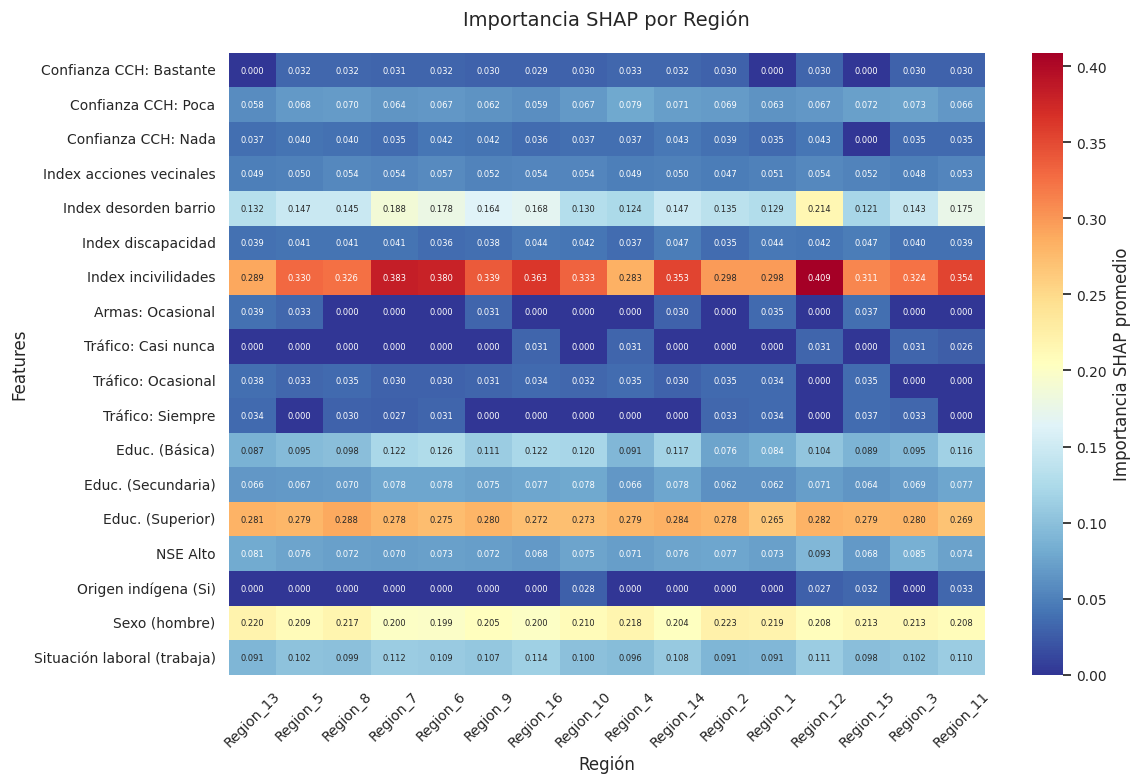

In [ ]:
# =========================================
# ANÁLISIS SHAP COMPREHENSIVO POR REGIÓN
# =========================================

# 1. PREPARACIÓN DE DATOS POR REGIÓN
def analisis_shap_regional(modelo, X_test_clean, y_test, regiones_test, min_obs=50):

    # Calcular SHAP values globales
    explainer = shap.TreeExplainer(modelo)
    shap_values = explainer.shap_values(X_test_clean)

    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Clase positiva

    # Crear DataFrame para análisis
    df_shap = pd.DataFrame(
        shap_values,
        columns=X_test_clean.columns,
        index=X_test_clean.index
    )
    df_shap['region'] = regiones_test.values
    df_shap['victimizacion'] = y_test.values

    # Filtrar regiones con suficientes observaciones
    region_counts = df_shap['region'].value_counts()
    regiones_validas = region_counts[region_counts >= min_obs].index
    df_shap_filtrado = df_shap[df_shap['region'].isin(regiones_validas)]

    print(f"Regiones analizadas: {len(regiones_validas)}")
    print(f"Observaciones por región:")
    for region in regiones_validas:
        n_obs = (df_shap_filtrado['region'] == region).sum()
        n_vict = df_shap_filtrado[df_shap_filtrado['region'] == region]['victimizacion'].sum()
        print(f"  Región {region}: {n_obs} obs, {n_vict} víctimas ({n_vict/n_obs:.1%})")

    return df_shap_filtrado, regiones_validas

# 2. IMPORTANCIA DE FEATURES POR REGIÓN
def importancia_por_region(df_shap, regiones_validas, top_n=10):

    feature_cols = [col for col in df_shap.columns if col not in ['region', 'victimizacion']]
    importancia_regional = {}

    for region in regiones_validas:
        region_data = df_shap[df_shap['region'] == region]

        # Importancia = promedio de valor absoluto SHAP
        importancia = region_data[feature_cols].abs().mean().sort_values(ascending=False)

        importancia_regional[f'Region_{region}'] = importancia.head(top_n)

    # Crear DataFrame comparativo
    df_importancia = pd.DataFrame(importancia_regional).fillna(0)
    return df_importancia

# 3. HEATMAP COMPARATIVO DE IMPORTANCIA
def plot_heatmap_regional(df_importancia, titulo="Importancia SHAP por Región"):
    plt.figure(figsize=(12, 8))

    # Obtener etiquetas descriptivas
    feature_names = df_importancia.index
    etiquetas = [obtener_etiqueta(feat) for feat in feature_names]

    # Crear heatmap
    sns.heatmap(
        df_importancia,
        annot=True,
        fmt='.3f',
        cmap='RdYlBu_r',
        cbar_kws={'label': 'Importancia SHAP promedio'},
        yticklabels=etiquetas,
        annot_kws={'size': 6}
    )

    plt.title(titulo, fontsize=14, pad=20)
    plt.xlabel('Región', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 5. ANÁLISIS DE HETEROGENEIDAD ESTADÍSTICA
def test_heterogeneidad_regional(df_shap, regiones_validas, feature, alpha=0.05):
    grupos_shap = []
    nombres_grupos = []

    for region in regiones_validas:
        shap_region = df_shap[df_shap['region'] == region][feature].abs()
        if len(shap_region) >= 10:  # Mínimo para test
            grupos_shap.append(shap_region)
            nombres_grupos.append(f'Region_{region}')

    if len(grupos_shap) >= 3:
        # ANOVA de una vía
        stat, p_value = stats.f_oneway(*grupos_shap)

        resultado = {
            'feature': feature,
            'n_regiones': len(grupos_shap),
            'f_statistic': stat,
            'p_value': p_value,
            'significativo': p_value < alpha
        }

        return resultado
    else:
        return None

# 6. EJECUTAR ANÁLISIS COMPLETO
print("EJECUTANDO ANÁLISIS SHAP REGIONAL...")

# Análisis principal
df_shap_regional, regiones_validas = analisis_shap_regional(
    mejores_modelos["XGBoost"],
    X_test_clean,
    y_test_strat,
    reg_test,  # variable de región en test
    min_obs=5
)

# Importancia por región
df_importancia_regional = importancia_por_region(df_shap_regional, regiones_validas, top_n=15)

# Visualizaciones
plot_heatmap_regional(df_importancia_regional)

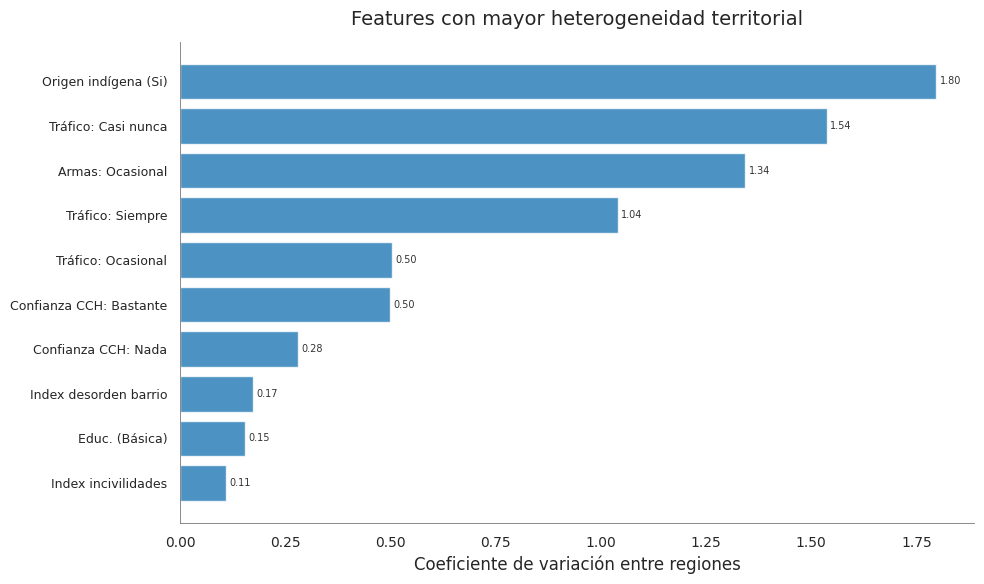

In [ ]:
# 8. GRÁFICO DE VARIABILIDAD

def plot_variabilidad_regional(df_importancia):

    # top-10 coeficiente de variación
    cv = (df_importancia.std(axis=1) / df_importancia.mean(axis=1)) \
            .sort_values(ascending=False).head(10)

    etiquetas = [obtener_etiqueta(f) for f in cv.index]

    plt.figure(figsize=(10, 6))
    sns.set_style("white")
    bars = plt.barh(
        y     = range(len(cv)),
        width = cv.values,
        color = "#1f77b4",
        alpha = 0.8
    )

    plt.yticks(range(len(cv)), etiquetas, fontsize=9)
    plt.xlabel("Coeficiente de variación entre regiones")
    plt.title("Features con mayor heterogeneidad territorial", pad=12)
    plt.gca().invert_yaxis()

    ax = plt.gca()
    for side in ("bottom", "left"):
        ax.spines[side].set_color("#777777")
        ax.spines[side].set_linewidth(0.6)
    for side in ("top", "right"):
        ax.spines[side].set_visible(False)

    plt.grid(False)

    # valores al final de cada barra
    for i, v in enumerate(cv.values):
        plt.text(v + 0.008, i, f"{v:.2f}",
                 va="center", fontsize=7, color="#333333")

    plt.tight_layout()
    plt.show()

# Llamar la función
plot_variabilidad_regional(df_importancia_regional)

### **Gráficos de dependencia SHAP: Análisis de relaciones no-lineales**

* La **identificación de top features** para análisis de dependencia prioriza variables con mayor importancia SHAP global, enfocando los recursos computacionales en predictores más influyentes. La verificación de disponibilidad de mapas de etiquetas descriptivas a nombres originales de columnas, asegura que las variables seleccionadas para el análisis detallado estén realmente presentes en el conjunto de datos procesado y puedan ser visualizadas correctamente.

* Los **gráficos de dependencia SHAP** revelan cómo se relacionan los valores de las características con sus contribuciones SHAP, exponiendo relaciones no lineales, efectos de umbral y patrones de interacción no capturados por clasificaciones simples de importancia de características. El manejo robusto de errores previene fallas cuando características específicas presentan problemas durante el trazado, asegurando que el análisis continúe incluso si fallan gráficos individuales.


Variables analizadas:
  1. Index incivilidades: 0.3368
  2. Educ. (Superior): 0.2788
  3. Sexo (hombre): 0.2109
  4. Index desorden barrio: 0.1514

Generando gráficos para 4 variables


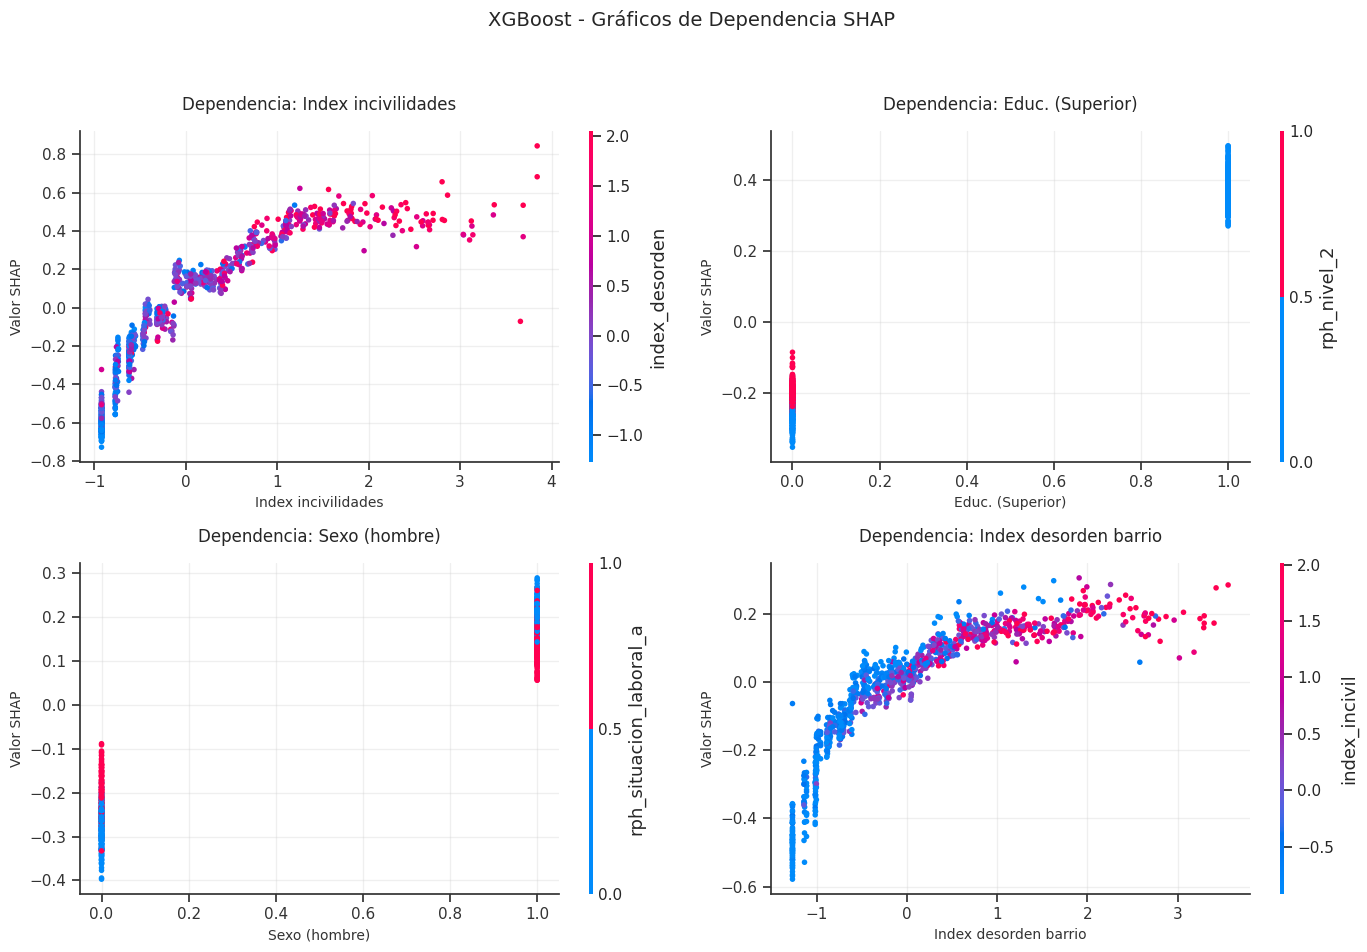


Index incivilidades:
  Rango: [-0.922, 3.843]
  Media: -0.003
  SHAP promedio: 0.3368
  Correlación valor-SHAP: 0.882
  Relación positiva fuerte

Educ. (Superior):
  Rango: [0.000, 1.000]
  Media: 0.361
  SHAP promedio: 0.2788
  Correlación valor-SHAP: 0.990
  Relación positiva fuerte

Sexo (hombre):
  Rango: [0.000, 1.000]
  Media: 0.546
  SHAP promedio: 0.2109
  Correlación valor-SHAP: 0.975
  Relación positiva fuerte


In [ ]:
# ===========================================
# GRÁFICOS DE DEPENDENCIA SHAP
# ===========================================

# 1. SELECCIÓN DE VARIABLES CRÍTICAS
top_features = list(importancia_global.head(4)['Variable'])

print("Variables analizadas:")
for i, feature in enumerate(top_features, 1):
    importance = importancia_global[importancia_global['Variable'] == feature]['SHAP_Importance'].iloc[0]
    print(f"  {i}. {feature}: {importance:.4f}")

# 2. VERIFICACIÓN DE DISPONIBILIDAD
features_disponibles = []
original_cols = X_shap_clean.columns
for feature_label in top_features:
    original_feature_name = None
    for original_col, label in etiquetas_variables.items():
        if label == feature_label:
            original_feature_name = original_col
            break
    if original_feature_name is not None and original_feature_name in original_cols:
         features_disponibles.append(original_feature_name)
    else:
        print(f"Variable '{feature_label}' (original: {original_feature_name}) no disponible en datos procesados")


print(f"\nGenerando gráficos para {len(features_disponibles)} variables")

# 3. CONFIGURACIÓN DE VISUALIZACIÓN
n_features = len(features_disponibles)
if n_features >= 4:
    nrows, ncols = 2, 2
    figsize = (14, 10)
elif n_features == 3:
    nrows, ncols = 2, 2
    figsize = (14, 10)
elif n_features == 2:
    nrows, ncols = 1, 2
    figsize = (14, 6)
else:
    nrows, ncols = 1, 1
    figsize = (8, 6)

# 4. GENERACIÓN DE GRÁFICOS DE DEPENDENCIA
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
if not isinstance(axes, np.ndarray):
    axes = [axes]
else:
    axes = axes.ravel()
for i, feature in enumerate(features_disponibles):
    if i < len(axes):
        try:
            shap.dependence_plot(
                feature,
                shap_values,
                X_shap_clean,
                ax=axes[i],
                show=False
            )
            axes[i].set_title(f'Dependencia: {obtener_etiqueta(feature)}', fontsize=12, pad=15)
            axes[i].set_xlabel(obtener_etiqueta(feature), fontsize=10)
            axes[i].set_ylabel('Valor SHAP', fontsize=10)
            axes[i].grid(True, alpha=0.3)

        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error: {feature}\n{str(e)[:30]}...',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Error: {obtener_etiqueta(feature)}', fontsize=12)

# Ocultar ejes sobrantes
if n_features < len(axes):
    for j in range(n_features, len(axes)):
        axes[j].set_visible(False)

plt.suptitle(f'{nombre_modelo} - Gráficos de Dependencia SHAP', fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 5. ANÁLISIS CUANTITATIVO DE DEPENDENCIAS

for feature in features_disponibles[:3]:  # Top 3
    if feature in X_shap_clean.columns:
        # Estadísticas of the variable
        feature_data = X_shap_clean[feature]
        feature_shap = shap_values[:, list(X_shap_clean.columns).index(feature)]

        print(f"\n{obtener_etiqueta(feature)}:") # Use label for output
        print(f"  Rango: [{feature_data.min():.3f}, {feature_data.max():.3f}]")
        print(f"  Media: {feature_data.mean():.3f}")
        print(f"  SHAP promedio: {abs(feature_shap).mean():.4f}")

        # Correlation between value and SHAP
        correlation = np.corrcoef(feature_data, feature_shap)[0, 1]
        if not np.isnan(correlation):
            print(f"  Correlación valor-SHAP: {correlation:.3f}")

            if abs(correlation) > 0.5:
                direction = "positiva" if correlation > 0 else "negativa"
                print(f"  Relación {direction} fuerte")
            else:
                print(f"  Relación no lineal o débil")

## 7. Conclusiones <a name="seccion7"></a>

* La metodología desarrollada demuestra que es **posible predecir riesgo
individual de victimización manteniendo robustez territorial** en Chile. **XGBoost** alcanza el mejor rendimiento territorial (Score=0.412, F1=0.434) con efectividad en todas las regiones analizadas (F1 mínimo=0.294), superando Random Forest y SVM. El modelo puede **identificar ~44% de víctimas futuras** en el 20% superior de riesgo predicho, representando capacidad predictiva moderada pero relevante para las políticas que supera significativamente la focalización aleatoria para focalización de recursos preventivos.

* El análisis SHAP regional revela **variación estadísticamente significativa** en importancia de predictores entre regiones chilenas (p<0.001). Variables como Index incivilidades varían 41% entre territorios, Index desorden 77%, estableciendo evidencia empírica que **refuta enfoques "talla única"** en políticas de seguridad. Algunos predictores son universales (incivilidades, educación), mientras que otros son territorialmente específicos (tráfico de drogas, organización comunitaria), informando necesidad de políticas con componentes nacionales y adaptación regional.

* Los resultados proporcionan **validación cuantitativa rigurosa** de teorías criminológicas convencionales. Index incivilidades emerge como predictor principal, confirmando Teoría de Ventanas Rotas. Variables de exposición a criminalidad validan Teoría de Actividades Rutinarias. Organización muestra comunitaria efectos protectores consistentes con Eficacia Colectiva. Esta convergencia entre marcos teóricos y hallazgos empíricos fortalece los fundamentos conceptuales del modelo.

* El modelo demuestra **viabilidad para implementación nacional** con efectividad en >93% del territorio (15-16/16 regiones), estableciendo que ML puede ser herramienta práctica para focalización territorial. La heterogeneidad regional documentada sugiere que intervenciones efectivas requieren **adaptación según contexto local**: programas de percepción de seguridad en algunas regiones, fortalecimiento organizacional en otras. El marco desarrollado proporciona base empírica para la detección, asignación de recursos y priorización territorial de intervenciones preventivas.

* Este trabajo establece el **un punto de referencia riguroso de ML para victimización** en Chile, integrando una metodología espacial con interpretabilidad SHAP que une la sofisticación técnica y la relevancia de las políticas. Las limitaciones incluyen dependencia en datos de encuestas, cobertura urbana limitada y ausencia de variables institucionales/económicas críticas. Futuras propuestas deben integrar datos administrativos, desarrollar modelos longitudinales y realizar validación operativa con instituciones para probar la efectividad del enfoque desarrollado en el mundo real.